# We will show in this notebook that EKF can easily diverge due to the snowballing effect of poor linearization made at inaccurate $\hat{z}$. 

We will only consider the centralized EKF in a static sensor settings to prove our points.

In [6]:

%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import animation, rc
from matplotlib.lines import Line2D

from IPython.display import HTML

import pickle as pkl
import networkx as nx
from matplotlib import style
import jax.numpy as jnp
from jax import jacfwd, jit,grad
from functools import partial


from Robot import Robot
from virtual_sensor import virtual_sensor
from utils.DynamicFilters import getDynamicFilter,joint_meas_func
from utils.FIMPathPlanning import FIM_ascent_path_planning 
from utils.dLdp import FIM,FIM_mix,analytic_dLdp,analytic_dhdz
from utils.regions import CircleExterior
from tracking_log import logger



%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
class EKF:
    """
        The distributed version of Extended Kalman Filter, used by a single robot to estimate the source location from the information shared by its local teammates via comm.
        
        The major difference of this estimator from the conventional EKF is that the measurement function may be changing in time, so are the dimensions of y_t and p_t, due to 
        the change in the group of local teammates, as a result of changing comm. network topology.
        
        The estimator assumes a constant-velocity source movement model, with the velocity to be the fundamental uncertainty.
    """
    def __init__(self,q_0,R_mag=1,Q_mag=1):
        '''
        q_0 should be a vector, the initial guess of source position.
        
        R_mag,Q_mag should be scalars.
        '''
        
        self.q = q_0 # Mean
        self.qdot = np.zeros(self.q.shape) # Velocity Mean
        
        self.z = np.hstack([self.q,self.qdot]) # The source state
        
        
        self.qdim = len(self.q)
        
        self.P = np.eye(len(self.z)) # Covariance of [q,qdot]. Initialized to be the identity matrix
        
        self.R_mag = R_mag 
        self.Q_mag = Q_mag
        self._K = 0
        self._C=0
        self._yhat = 0
    
    def dfdz(self,z):
        n = len(z)//2
        O =np.zeros((n,n))
        I=np.eye(n)
        return np.vstack([np.hstack([I,I]),np.hstack([O,I])])

    def f(self,z):
        """
            The constant velocity model.
        """
        A = self.dfdz(z)
        
        return A.dot(z)
    def update(self,h,dhdz,y,p):
        """
        h is a function handle h(z,p), the measurement function that maps z,p to y.
        dhdz(z,p) is its derivative function handle.
        
        y is the actual measurement value, subject to measurement noise.
        
        p is the positions of the robots.
        """
        A = self.dfdz(self.z)
        C = dhdz(self.z,p)
        R = self.R_mag*np.eye(len(y))
        Q = self.Q_mag*np.eye(len(self.z))
        
        # The Kalman Gain
        K = A.dot(self.P).dot(C.T).dot(    np.linalg.inv(C.dot(self.P).dot(C.T)+R)      )
        self._K=K
        self._C=C

        # Mean and covariance update
        self._yhat = h(self.z,p)
        self.z = self.f(self.z)+K.dot(y-h(self.z,p))
        
        
        self.P = A.dot(self.P).dot(A.T)+ Q- K.dot(C.dot(self.P).dot(C.T)+R).dot(K.T)
        
    def update_and_estimate_loc(self,h,dhdz,y,p):
        if not np.any(y == np.inf):
            self.update(h,dhdz,y,p)

        return self.z[:len(self.q)]

    
        
        

In [33]:
def main(sensor_locs,src_locs,q_0,N_iter):
    # Set up mobile sensors and sources
    sensor_names = ["mobile_sensor_{}".format(i+1) for i in range(len(sensor_locs))]
    mobile_sensors = [Robot(loc,name) for loc,name in zip(sensor_locs,sensor_names)]
      
    src_names = ["source_{}".format(i+1) for i in range(len(src_locs))]
    source = [Robot(loc,name) for loc,name in zip(src_locs,src_names)]

    # Set up virtual sensors
    C1=0
    C0=0
    k=1
    b=-2
    std = 0.1
    vs = virtual_sensor(C1,C0,b,k,std)

    # Set up location estimator
    n_sen = len(mobile_sensors)
    n_src = len(source)

    C1s=C1*np.ones(n_sen)
    C0s = C0*np.ones(n_sen)
    ks = k * np.ones(n_sen)
    bs = b*np.ones(n_sen)  
  
    estimator = EKF(q_0,R_mag=0.1,Q_mag=0.1)

    # Set up data logger
    log = logger(sensor_names,src_names)
    log.est_locs_log =dict({'Estimation':[]})
    
    # Assume fixed topology, pre-set the measurement model and waypoint planner(expensive to be created in the main loop)
    ps = np.array([r.loc for r in mobile_sensors])
    qs = np.array([s.loc for s in source])
      
   
    h=partial(joint_meas_func,C1s,C0s,ks,bs)# Freeze the coefficients, the signature becomes h(z,ps)
    dhdz=partial(analytic_dhdz,C1s,C0s,ks,bs)
       
    # Enter main loop
    Ks = []
    Cs = []
    Ps = []
    ys = []
    yhats = []

    for _ in range(N_iter):
        # Measure
        ps = np.array([r.loc for r in mobile_sensors])
        qs = np.array([s.loc for s in source])
          
        y = vs.measurement(qs,ps)
          # Record
        for s in source:
            log.src_locs[s.name].append(s.loc)

        # Estimate.
        zhat = estimator.z

        qhat=estimator.update_and_estimate_loc(h,dhdz,y,ps)
       
        log.est_locs_log["Estimation"].append(zhat)
        Ks.append(estimator._K)
        Cs.append(estimator._C)
        Ps.append(estimator.P)
        ys.append(y)
        yhats.append(estimator._yhat)

    out=log.export()
    out['Ks']=Ks
    out['Cs']=Cs
    out['Ps']=Ps
    out['ys']=ys
    
    out['yhats']=yhats

    return out




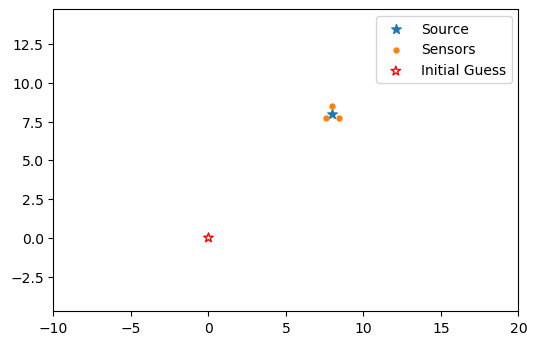

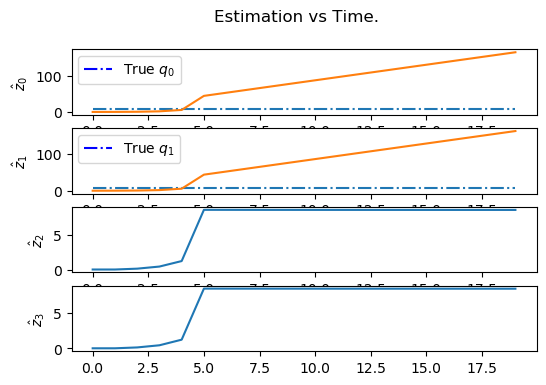

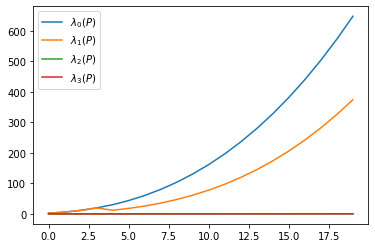

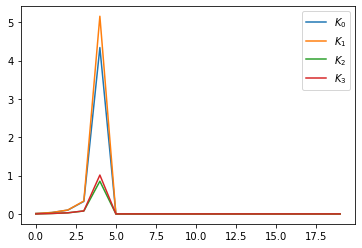

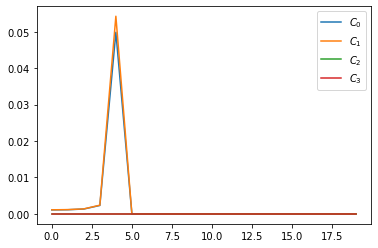

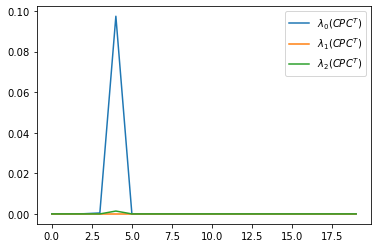

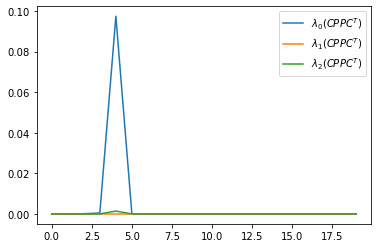

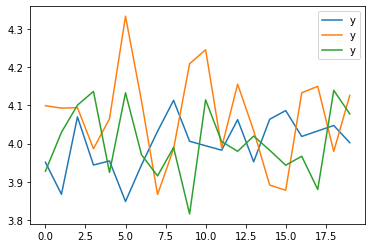

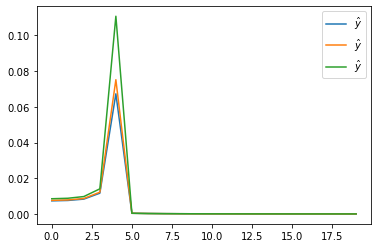

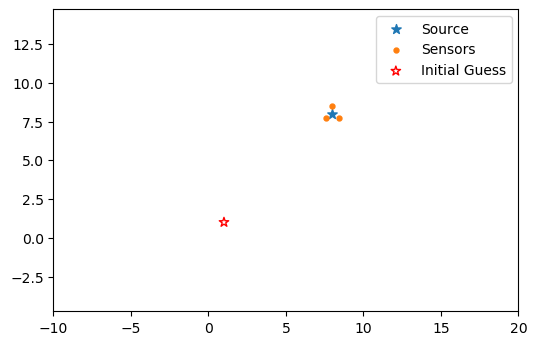

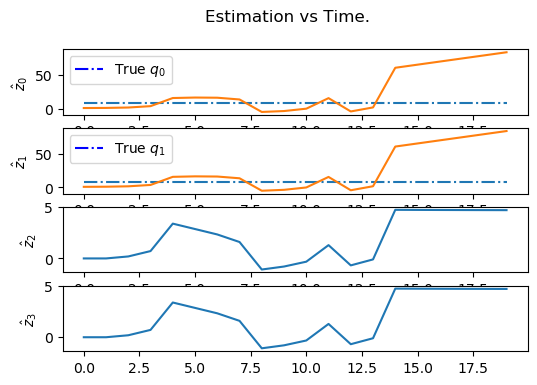

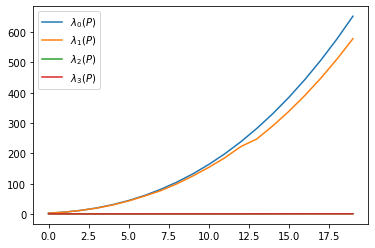

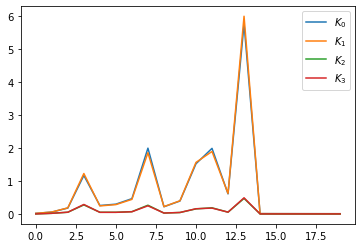

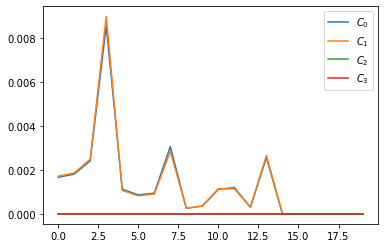

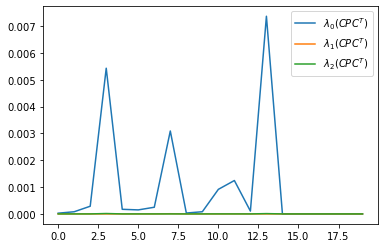

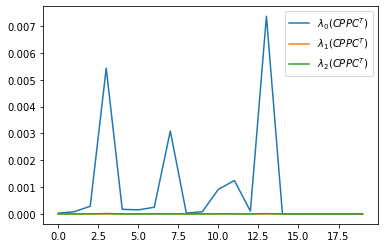

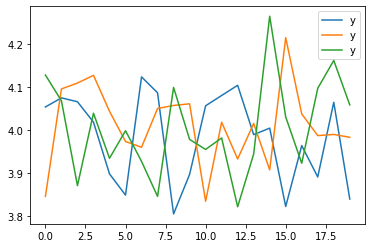

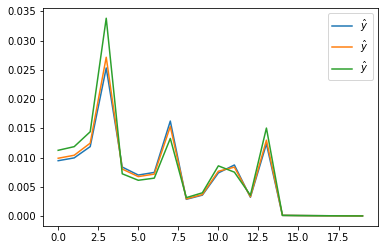

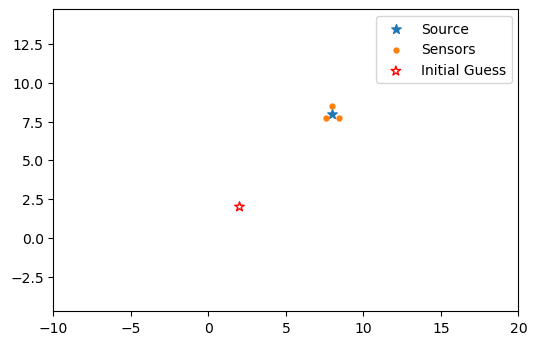

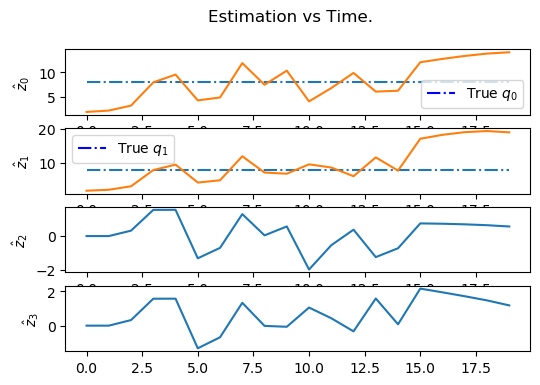

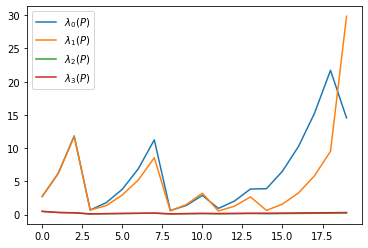

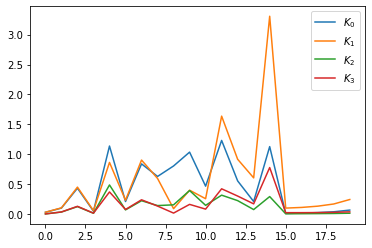

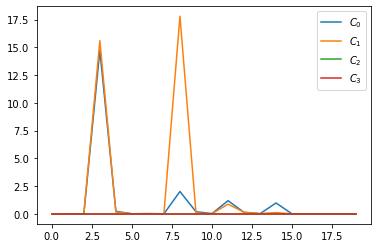

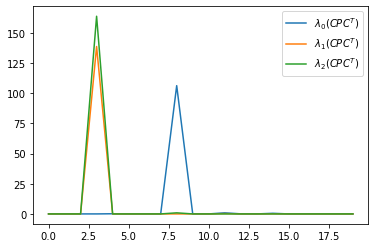

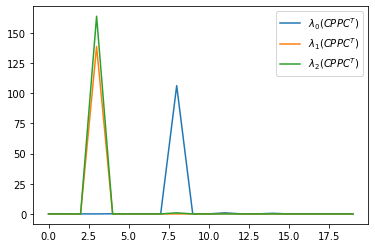

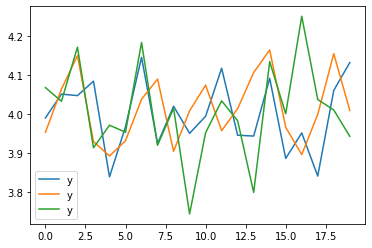

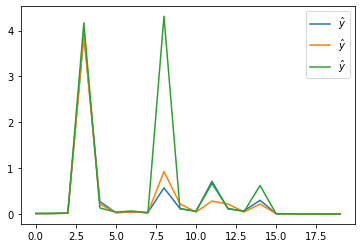

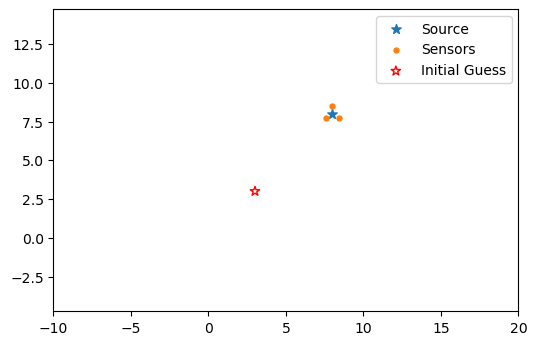

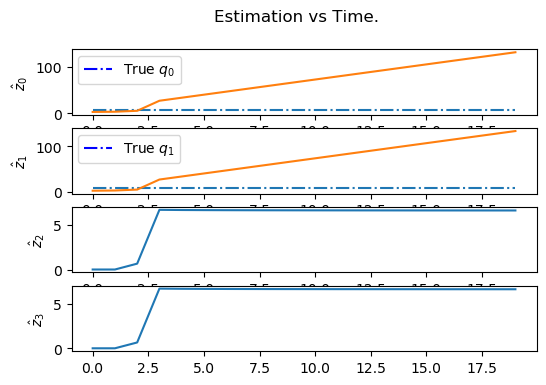

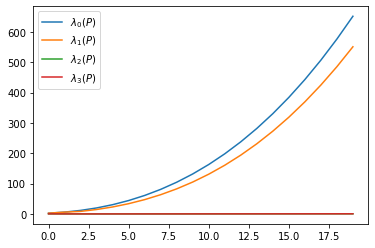

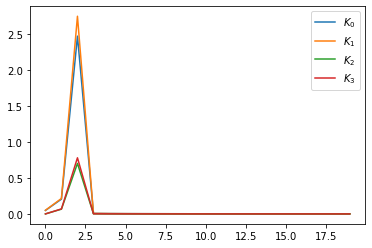

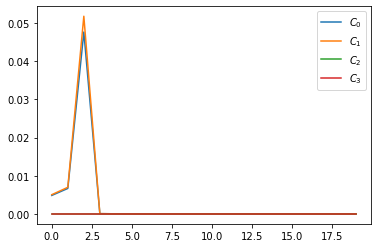

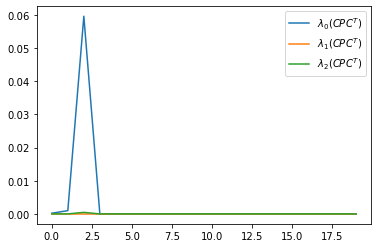

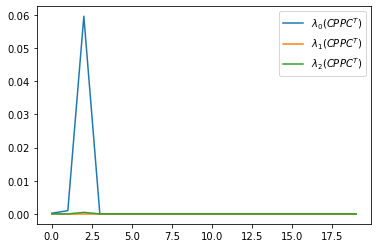

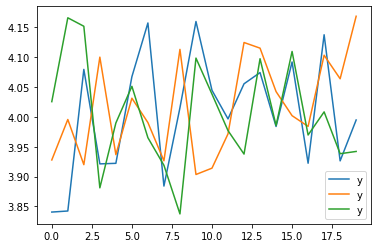

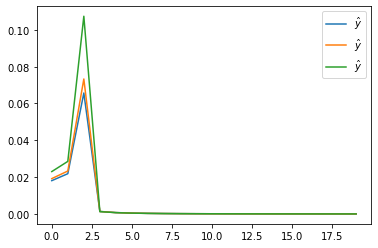

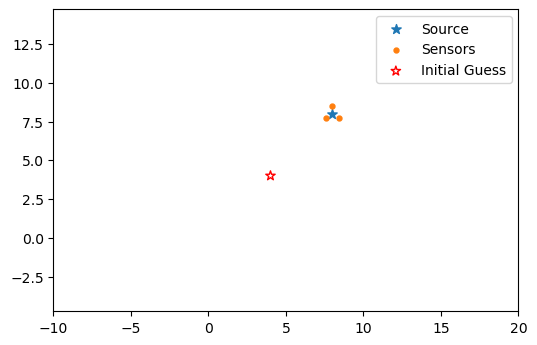

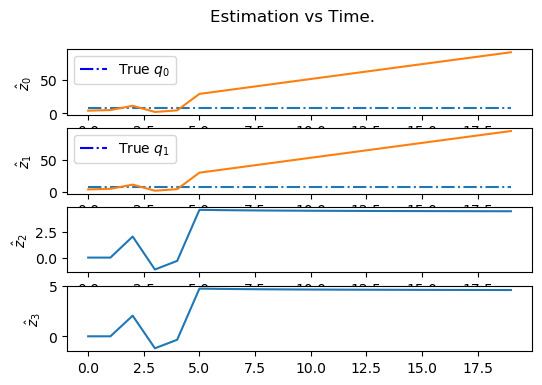

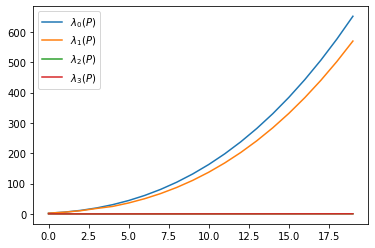

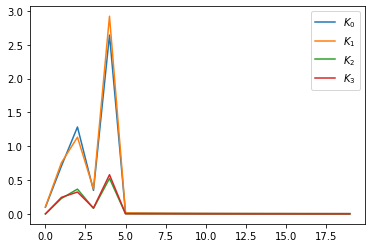

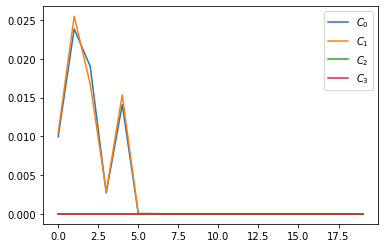

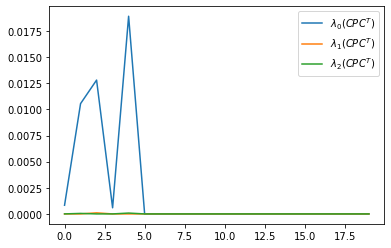

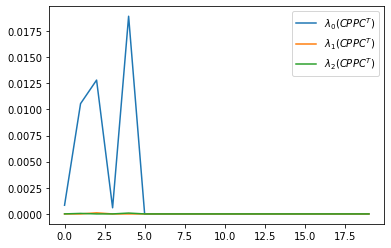

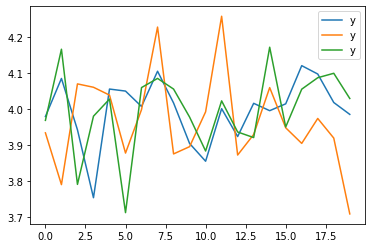

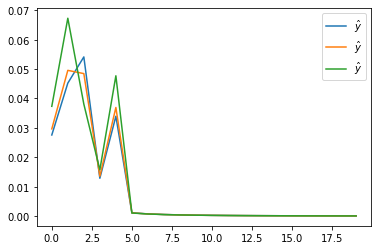

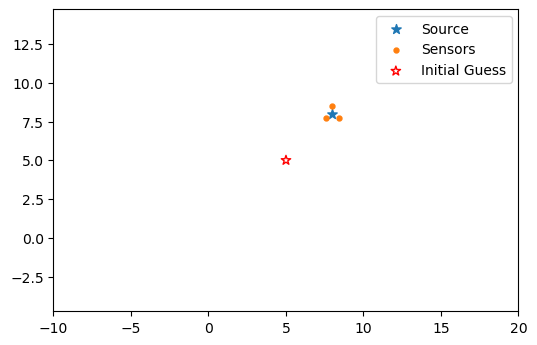

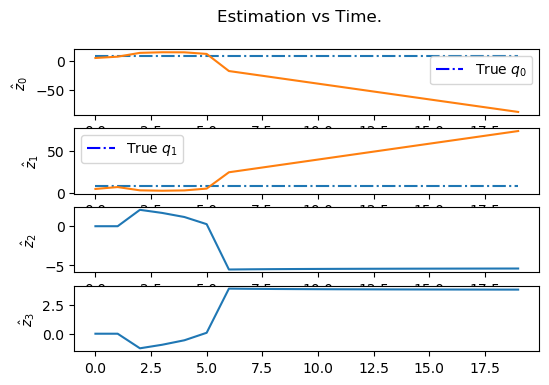

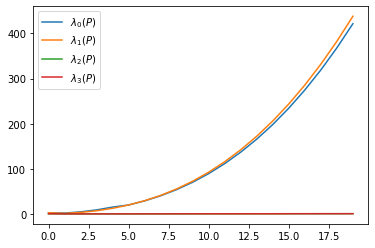

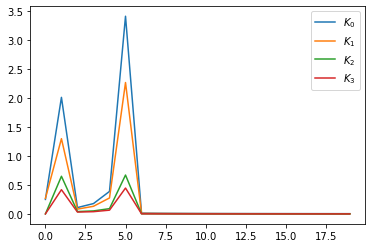

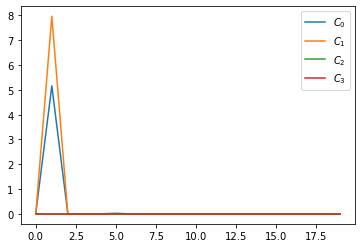

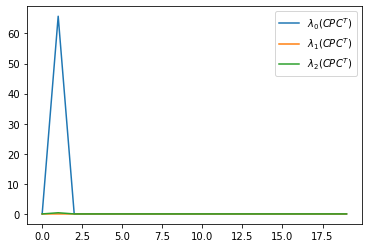

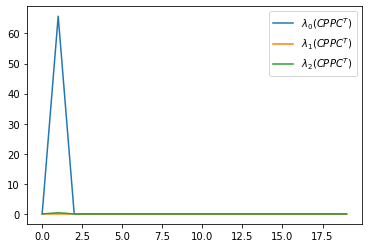

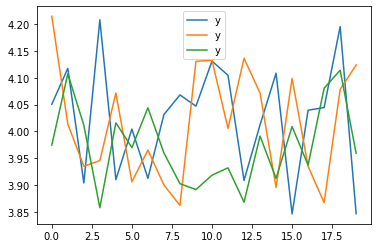

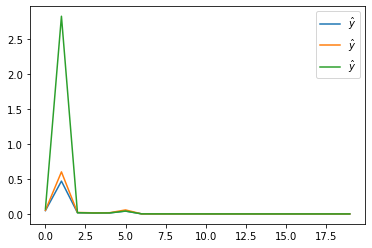

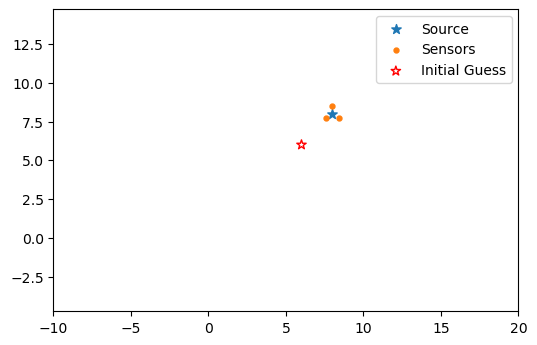

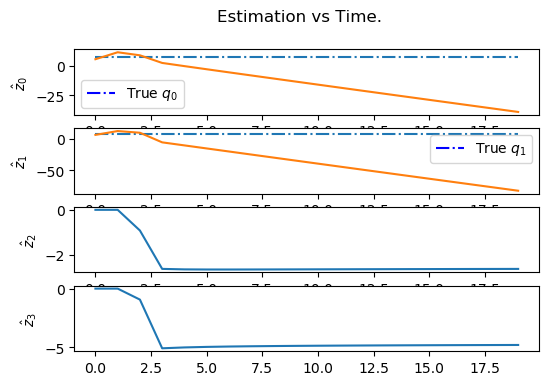

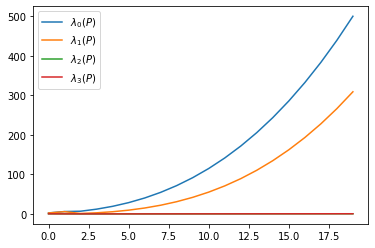

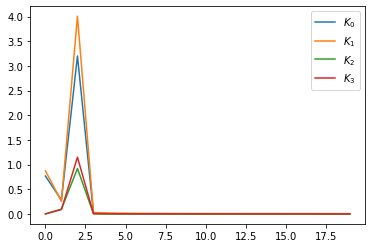

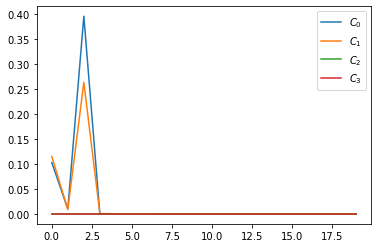

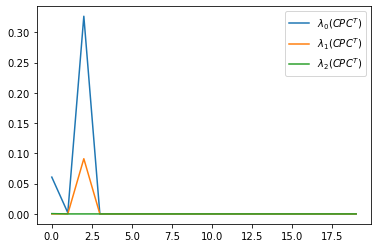

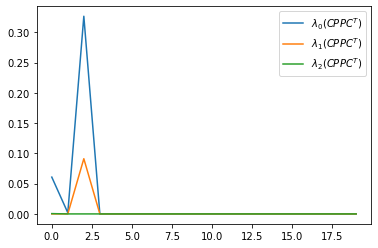

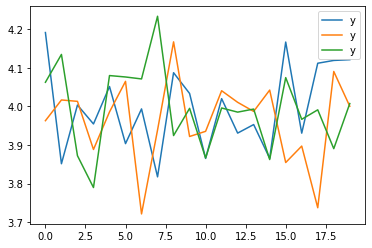

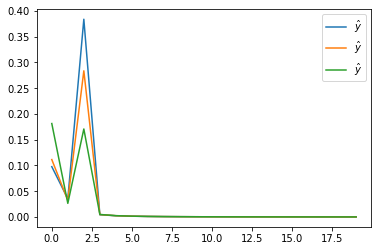

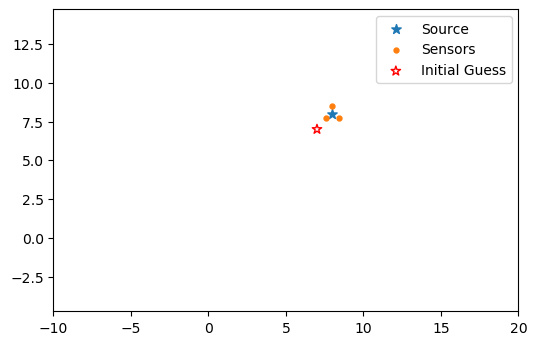

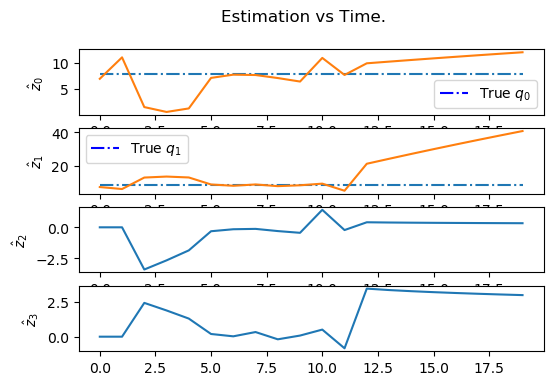

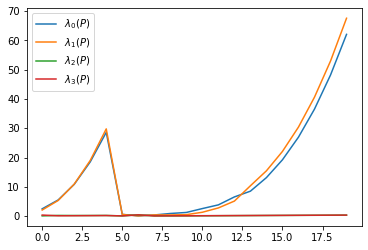

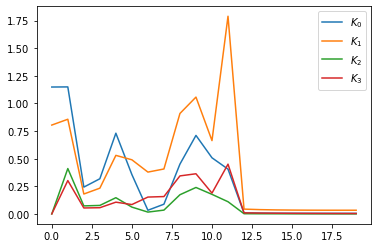

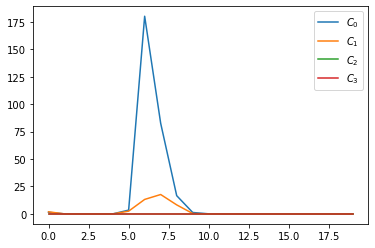

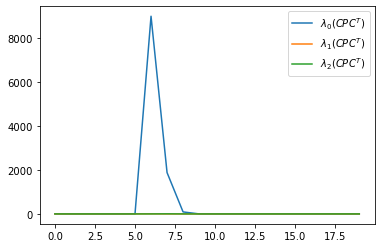

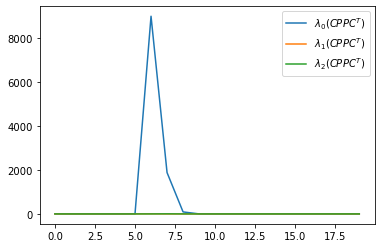

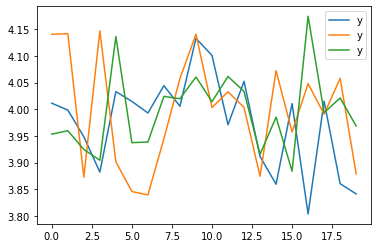

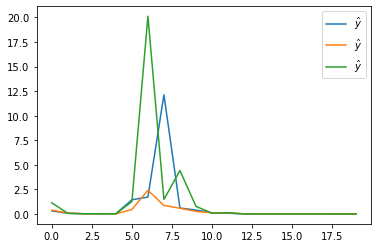

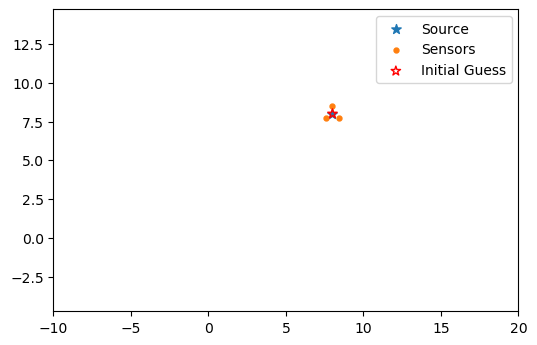

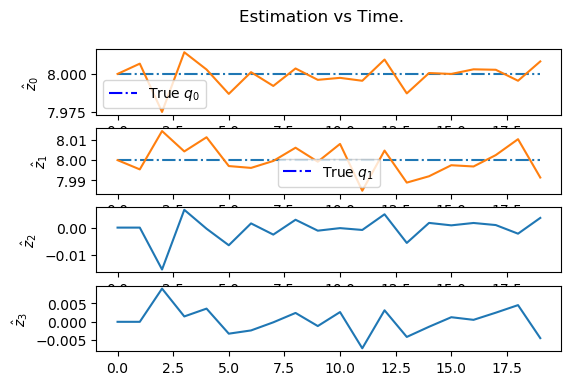

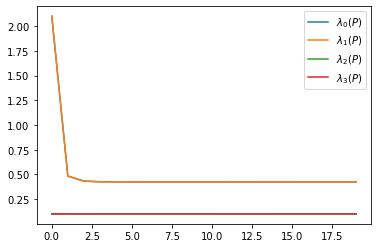

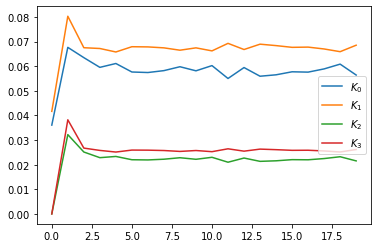

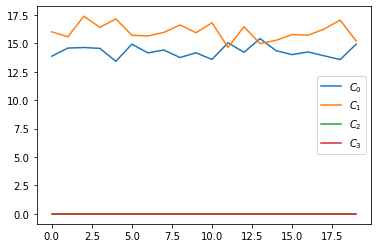

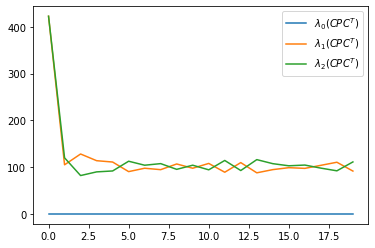

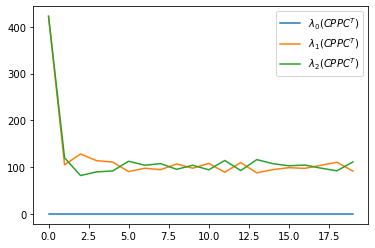

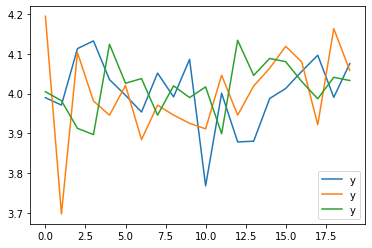

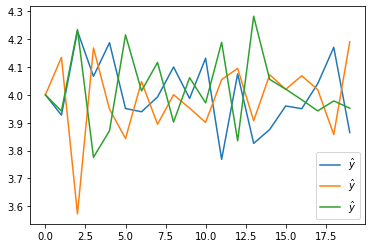

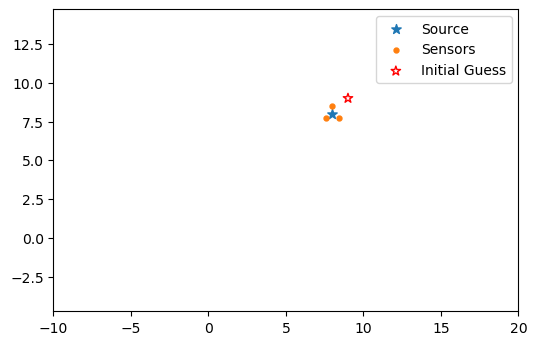

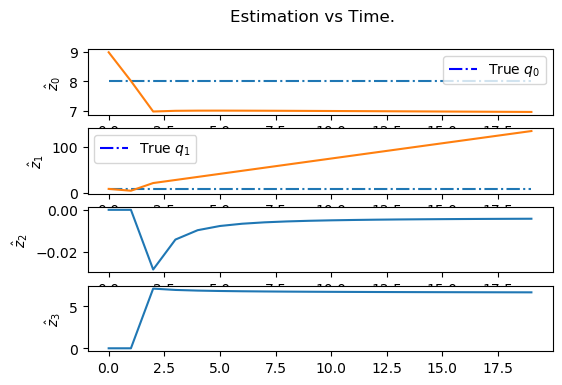

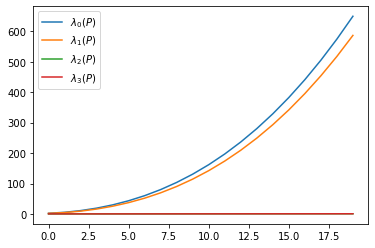

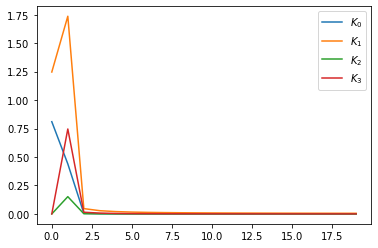

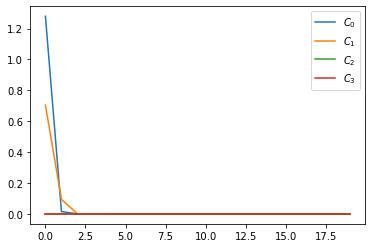

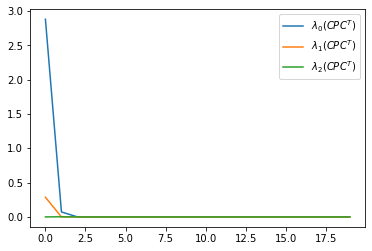

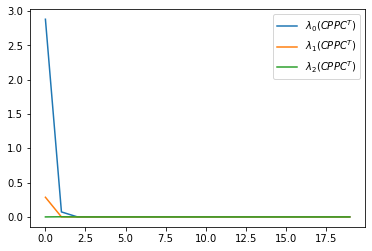

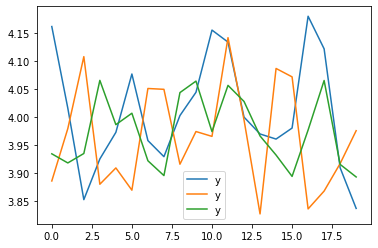

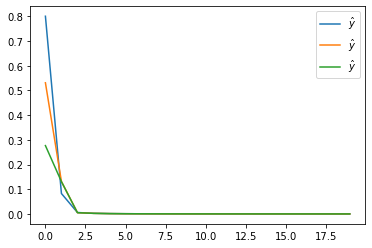

In [44]:
src_locs = np.array([[8.,8.]])
# sensor_center = src_locs
# r=0.5
# thetas = np.pi * 2 * np.linspace(0.5,0.75,3)
# sensor_locs =  r*np.vstack([np.sin(thetas),np.cos(thetas)]).T+sensor_center

r=0.5
thetas = np.pi * 2 * np.linspace(0,1,3,endpoint=False)
sensor_locs = r*np.vstack([np.sin(thetas),np.cos(thetas)]).T+np.array([[8.,8]])

# Simulating
initial_guesses = np.vstack([range(10),range(10)]).T
# initial_guesses = np.array([[6,6]])
recs = []
for i in range(len(initial_guesses)):
    q_0 = initial_guesses[i,:]
    record = main(sensor_locs,src_locs,q_0,20)
    recs.append(record)
    # filepath = "EKF-Div-Study.pkl"
    # with open(filepath,'wb') as file:
    #     pkl.dump(record,file)


# Visualization

for record in recs:
    zhats = record['est_locs_log']['Estimation']
    # Plot sensor, src locations, and qhats.

    fig, ax = plt.subplots(dpi=100)
    ax.cla()
    ax.scatter(src_locs[0,0],src_locs[0,1],marker='*',s=50,label='Source')
    ax.scatter(sensor_locs[:,0],sensor_locs[:,1],marker='.',s=50,label='Sensors')
#     ax.scatter(zhats[:,0],zhats[:,1],marker='*',s=50,label='Estimations',facecolor="None",edgecolor='b')
    ax.scatter(zhats[0,0],zhats[0,1],marker='*',s=50,label='Initial Guess',facecolor="None",edgecolor='r')

    ax.axis('on')
    ax.axis('equal')
    ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
    ax.set_xlim((-10,20))
    ax.set_ylim((-10,20))
    ax.legend()
    # ax.set_title()
    plt.show()


    # Plot z in time
    fig, ax = plt.subplots(4,dpi=100)

    fig.suptitle('Estimation vs Time.')
    for _ in range(4):
        if _<2:
            ax[_].plot(range(len(zhats)),src_locs[:,_]*np.ones(len(zhats)),'-.')
            custom_lines = [Line2D([0], [0], color='blue', ls='-.'),]
            ax[_].legend(custom_lines, ['True $q_{}$'.format(_)])
        for name,est in record['est_locs_log'].items():
            ax[_].plot(est[:,_])
            ax[_].set_ylabel(r'$\hat z_{}$'.format(_))
    plt.show()
    # Plot filtering parameters

    eig_P = np.array([np.linalg.eigvals(P) for P in record['Ps']])
#     print(eig_P)
    for i in range(eig_P.shape[1]):
        plt.plot(eig_P[:,i],label=r'$\lambda_{}(P)$'.format(i))
    plt.legend()
    plt.show()
    
    ave_K = np.array([np.max(np.abs(K),axis=1) for K in record['Ks']])
    for i in range(ave_K.shape[1]):
        plt.plot(ave_K[:100,i],label=r'$K_{}$'.format(i))
    plt.legend()
    plt.show()
    
    ave_C = np.array([np.max(np.abs(C),axis=0) for C in record['Cs']])
    for i in range(ave_C.shape[1]):
        plt.plot(ave_C[:20,i],label=r'$C_{}$'.format(i))
    plt.legend()
    plt.show()
    
    Ps = record['Ps']
    Cs = record['Cs']
    cPc = [C.dot(P).dot(C.T) for P,C in zip(Ps,Cs)]
    eig_cPc = np.array([np.abs(np.linalg.eigvals(A)) for A in cPc ])
    for i in range(eig_cPc.shape[1]):
        plt.plot(eig_cPc[:20,i],label=r'$\lambda_{}(CPC^T)$'.format(i))
    plt.legend()
    plt.show()
    
    cPPc = [C.dot(P).dot(P).dot(C.T) for P,C in zip(Ps,Cs)]
    eig_cPPc = np.array([np.abs(np.linalg.eigvals(cPPc)) for A in cPc ])
    for i in range(eig_cPc.shape[1]):
        plt.plot(eig_cPc[:20,i],label=r'$\lambda_{}(CPPC^T)$'.format(i))
    plt.legend()
    plt.show()
    
    
    plt.title("")
    plt.plot(record['ys'],label='y')
    plt.legend()
    plt.show()
  
    plt.plot(record['yhats'],label='$\hat{y}$')
    plt.legend()
    plt.show()
  

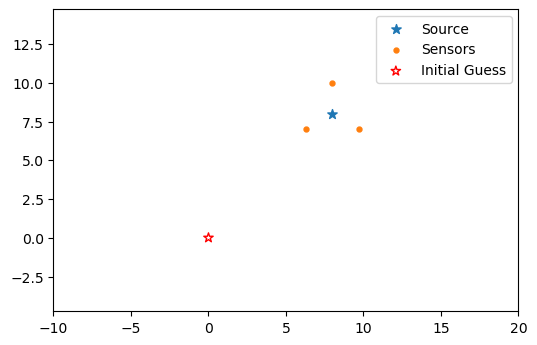

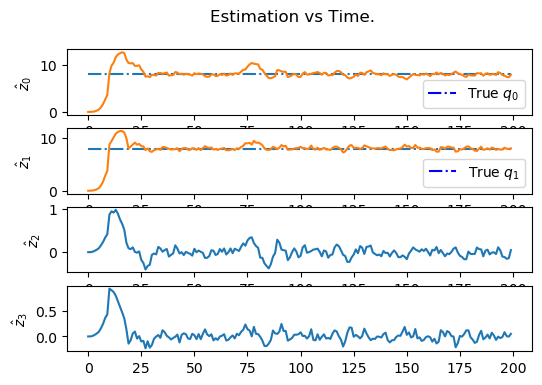

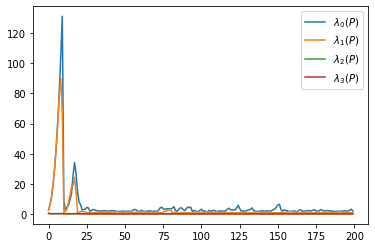

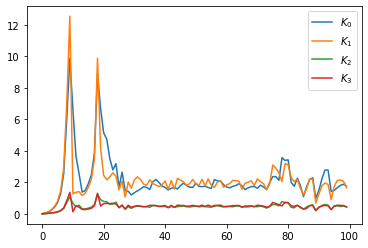

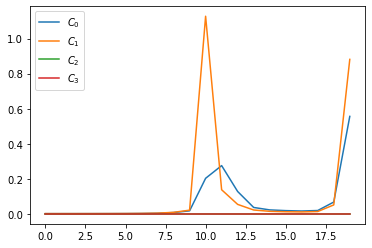

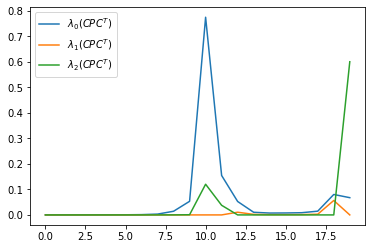

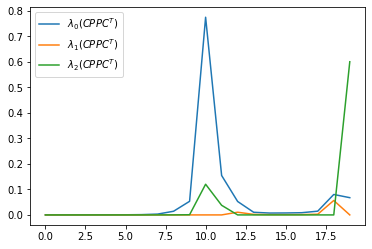

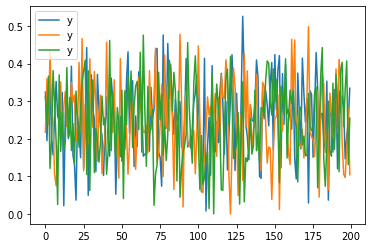

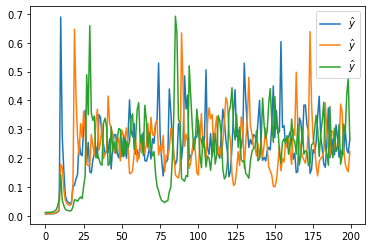

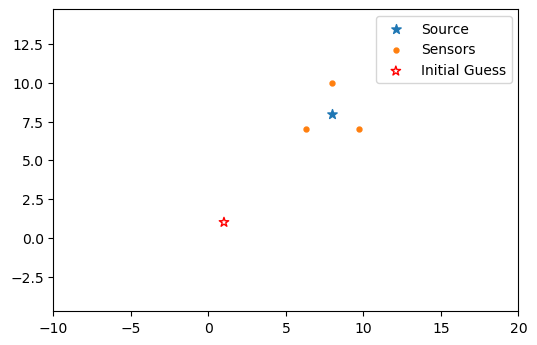

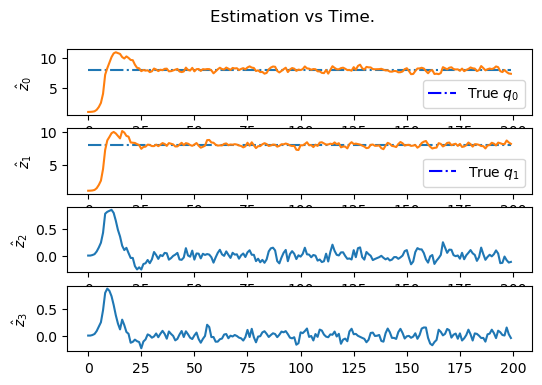

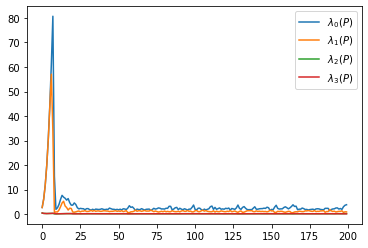

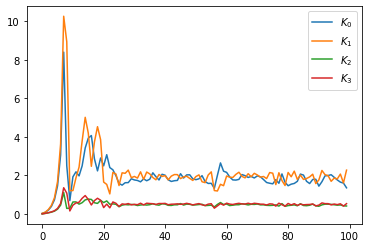

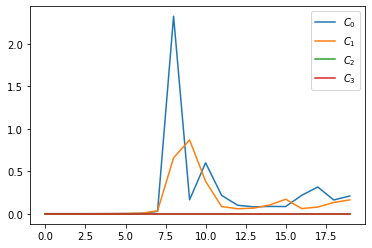

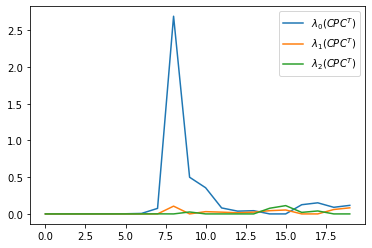

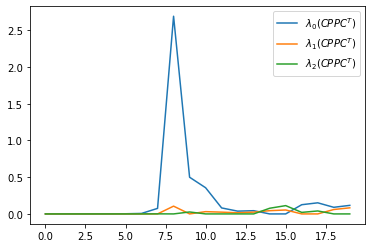

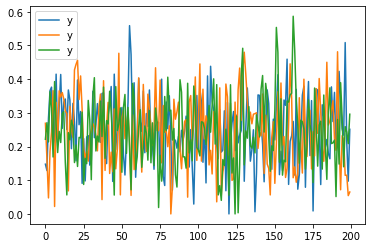

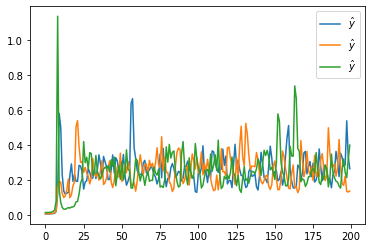

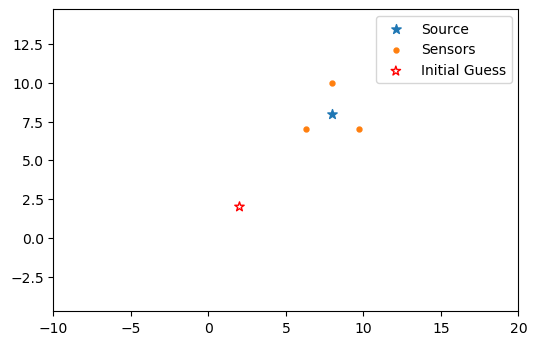

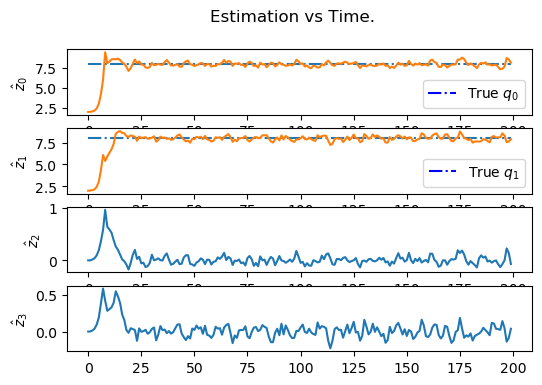

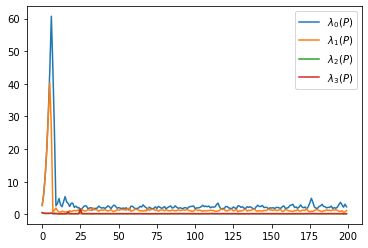

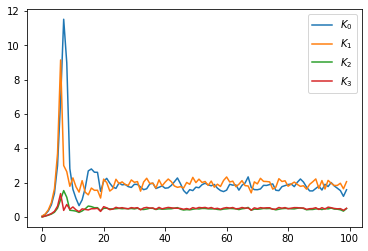

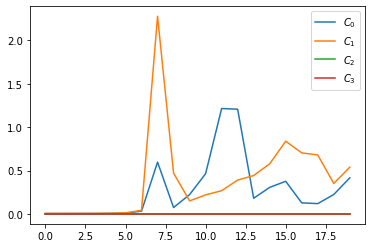

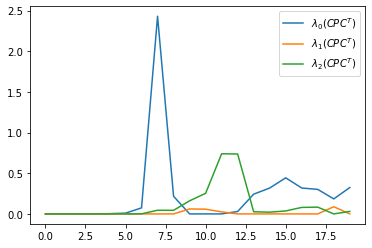

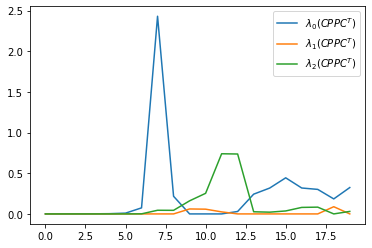

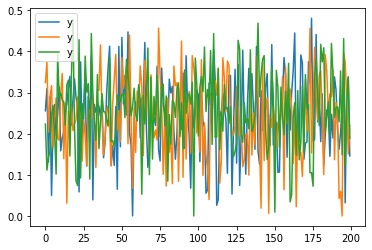

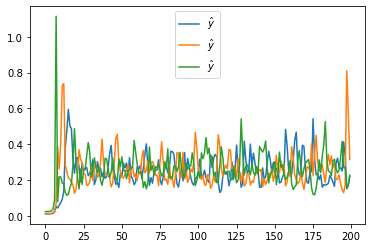

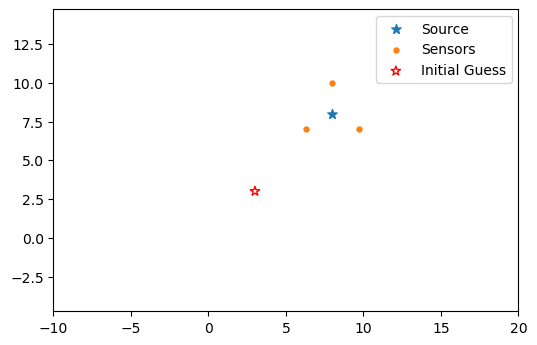

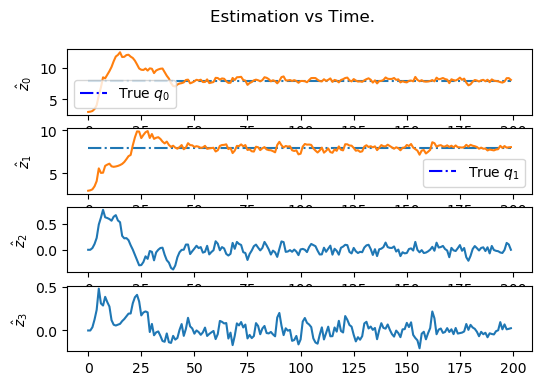

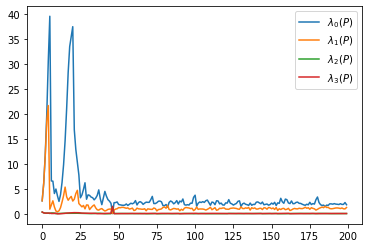

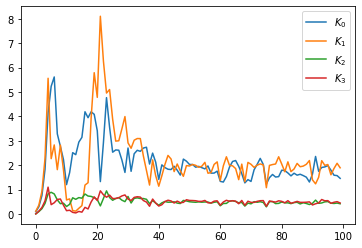

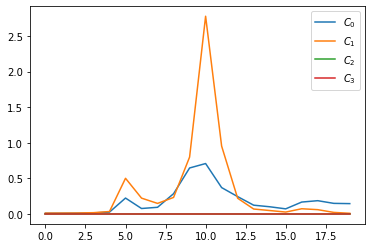

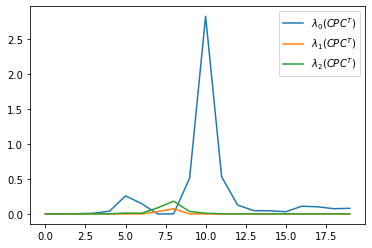

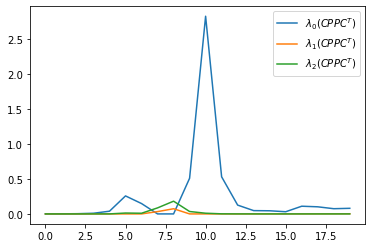

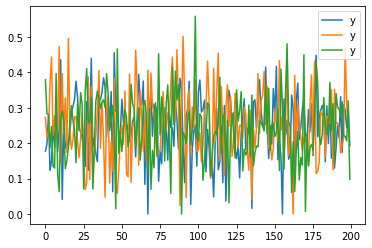

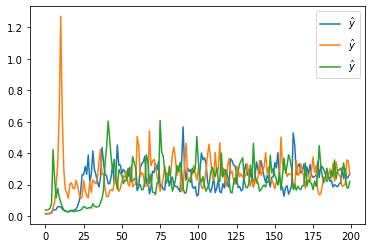

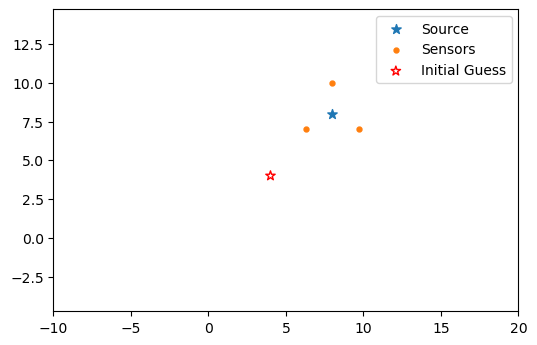

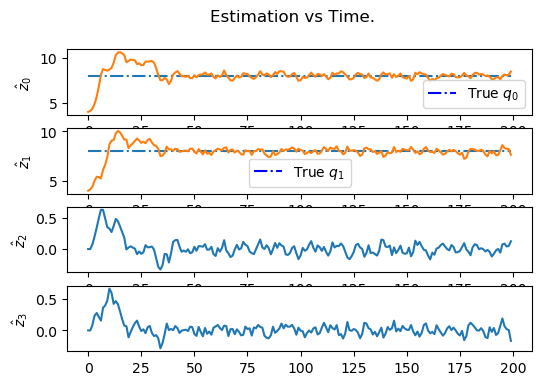

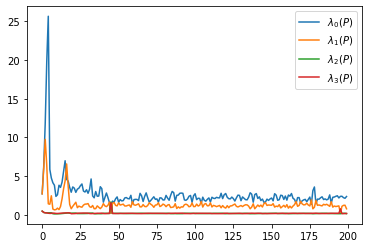

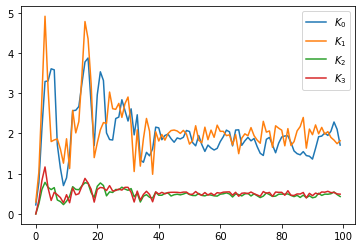

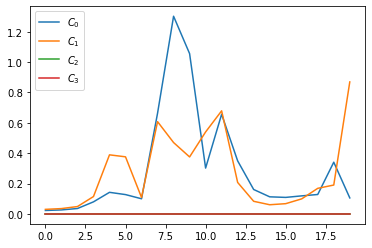

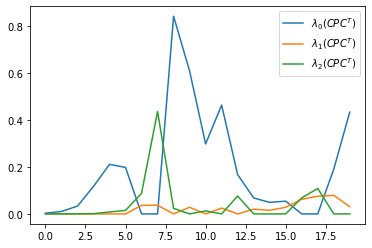

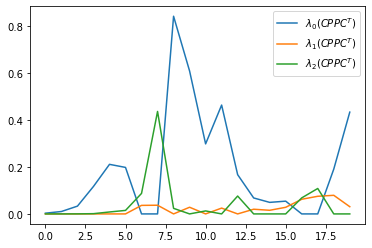

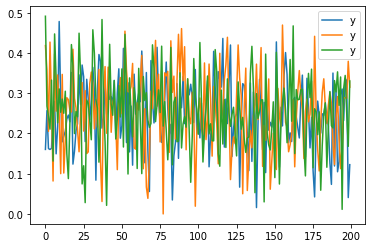

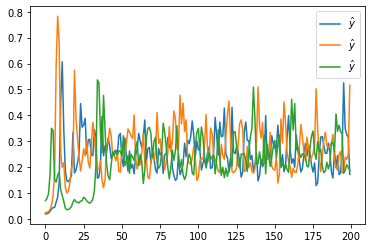

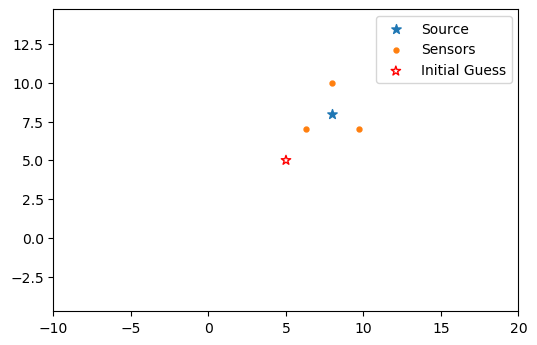

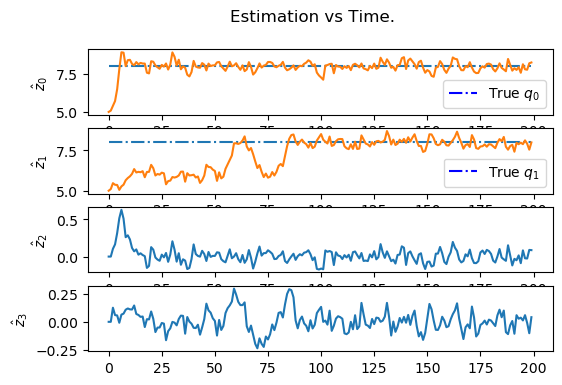

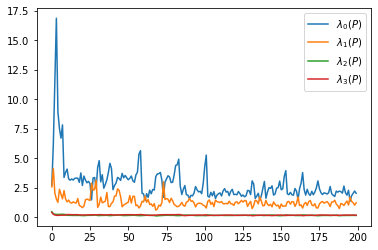

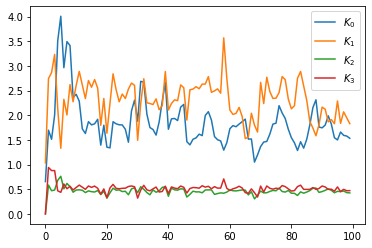

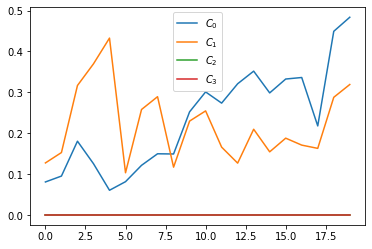

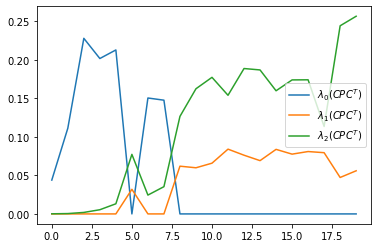

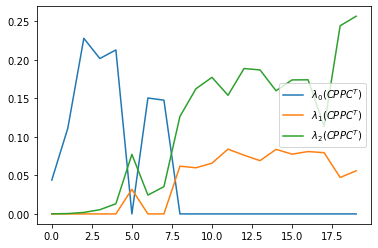

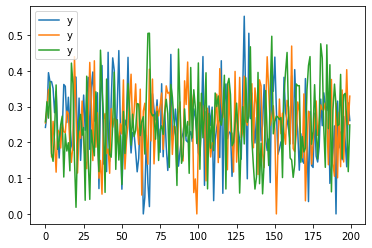

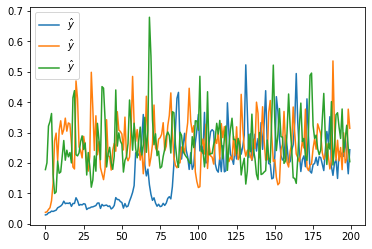

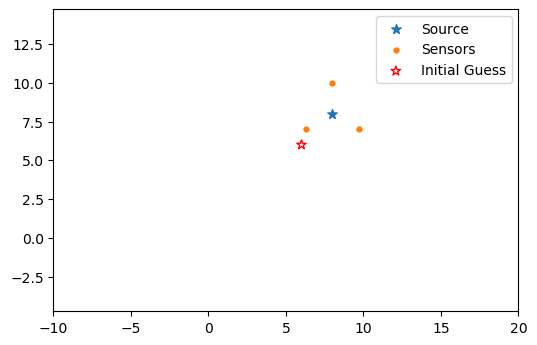

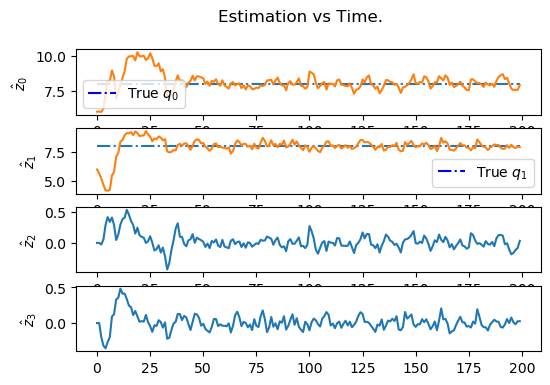

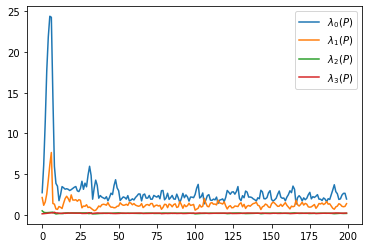

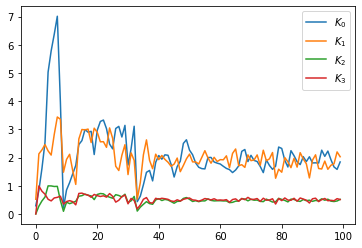

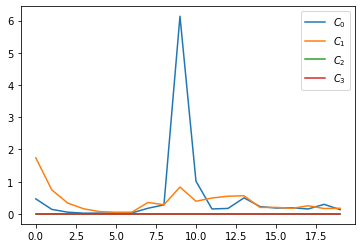

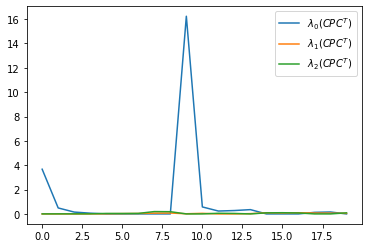

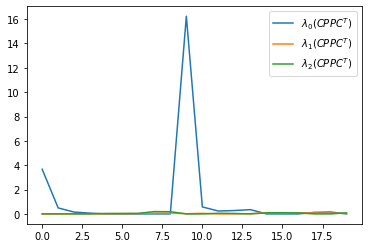

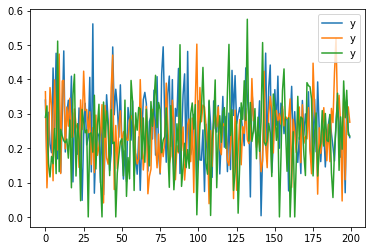

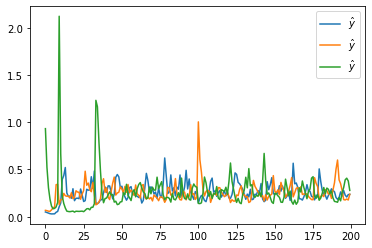

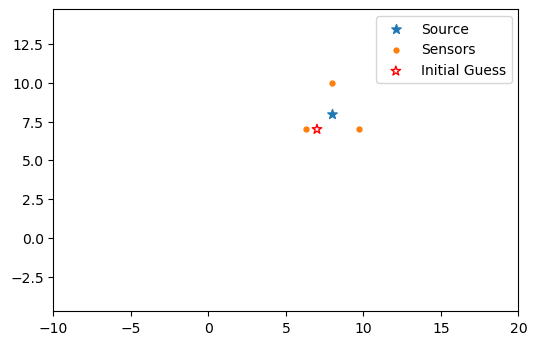

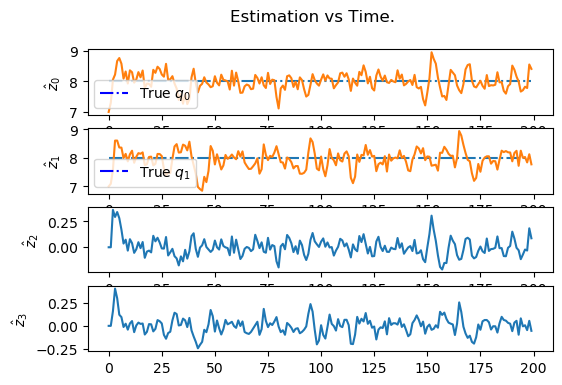

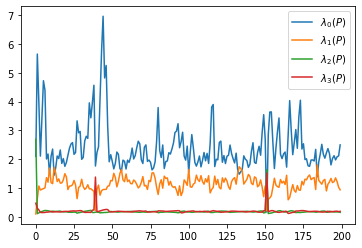

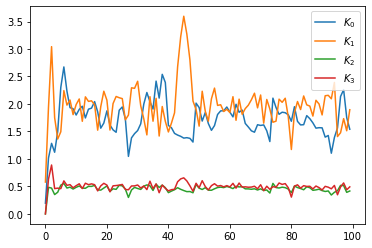

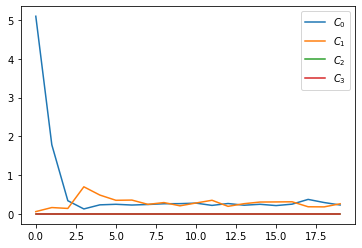

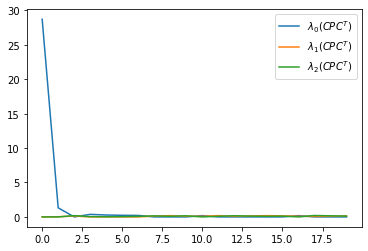

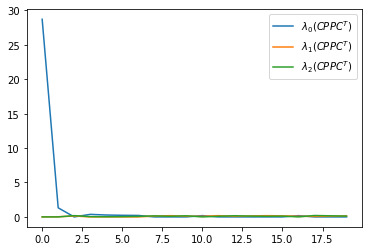

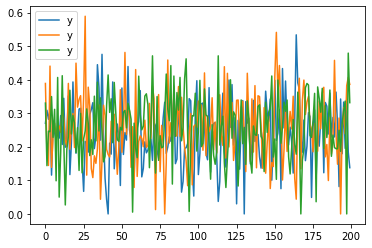

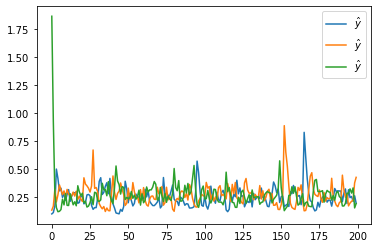

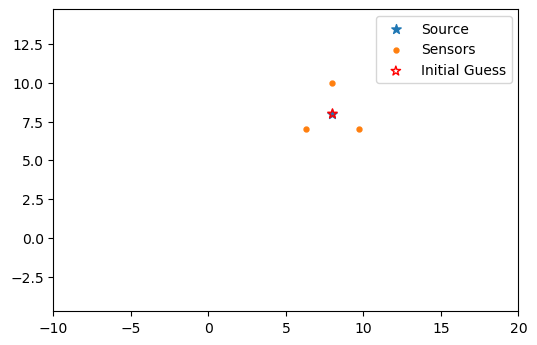

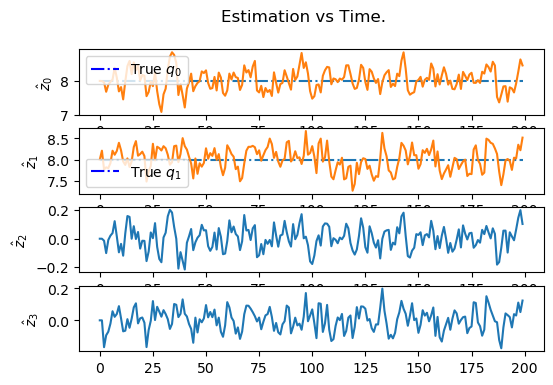

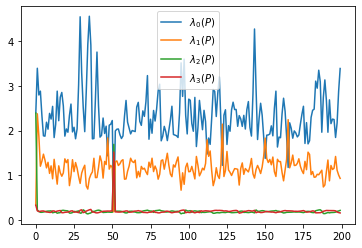

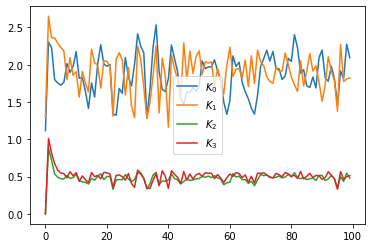

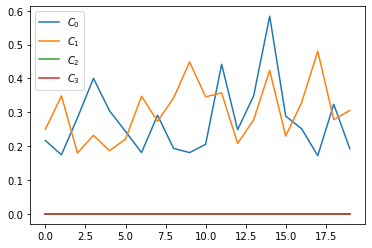

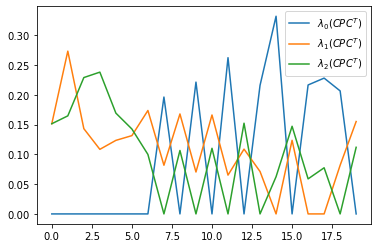

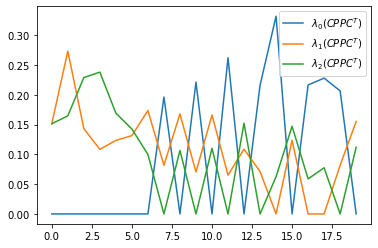

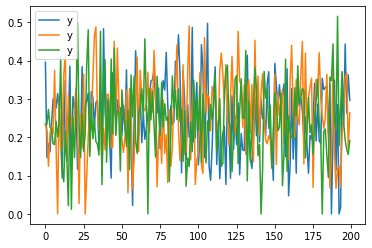

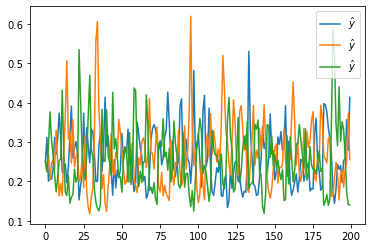

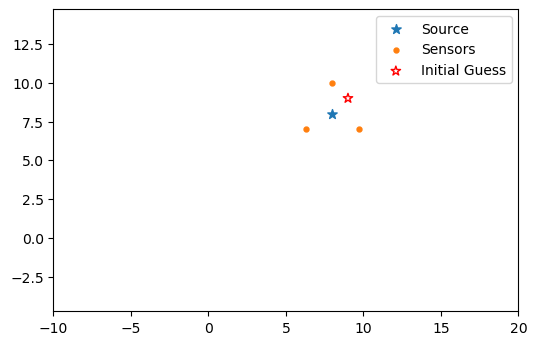

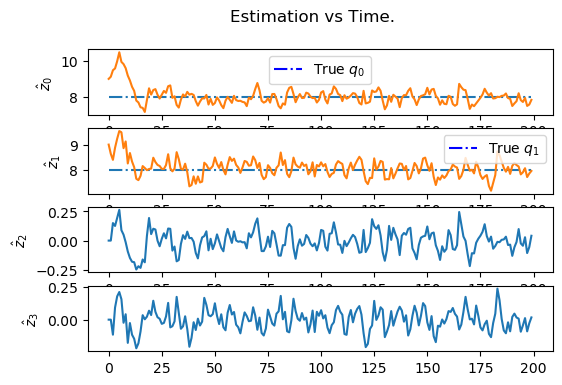

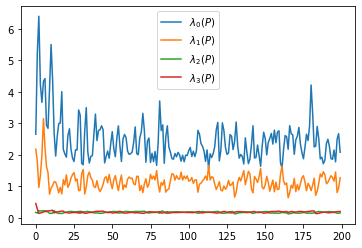

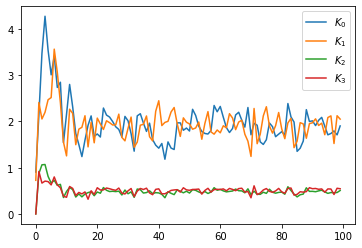

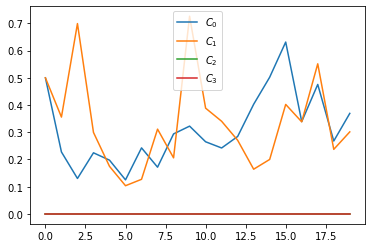

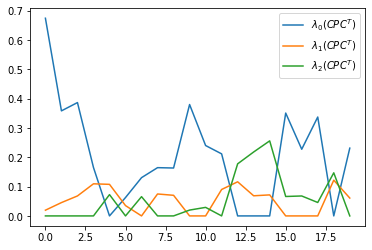

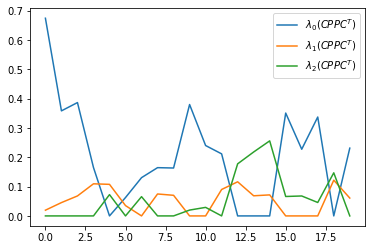

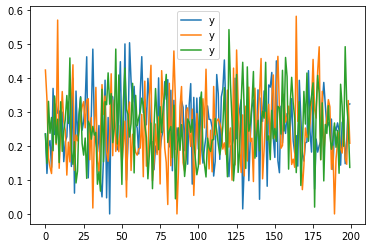

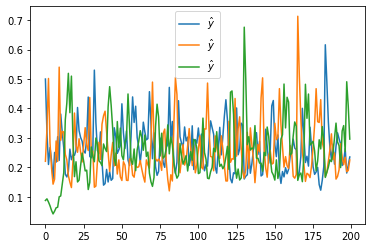

In [46]:
src_locs = np.array([[8.,8.]])
# sensor_center = src_locs
# r=0.5
# thetas = np.pi * 2 * np.linspace(0.5,0.75,3)
# sensor_locs =  r*np.vstack([np.sin(thetas),np.cos(thetas)]).T+sensor_center

r=2
thetas = np.pi * 2 * np.linspace(0,1,3,endpoint=False)
sensor_locs = r*np.vstack([np.sin(thetas),np.cos(thetas)]).T+np.array([[8.,8]])

# Simulating
initial_guesses = np.vstack([range(10),range(10)]).T
# initial_guesses = np.array([[6,6]])
recs = []
for i in range(len(initial_guesses)):
    q_0 = initial_guesses[i,:]
    record = main(sensor_locs,src_locs,q_0,200)
    recs.append(record)
    # filepath = "EKF-Div-Study.pkl"
    # with open(filepath,'wb') as file:
    #     pkl.dump(record,file)


# Visualization

for record in recs:
    zhats = record['est_locs_log']['Estimation']
    # Plot sensor, src locations, and qhats.

    fig, ax = plt.subplots(dpi=100)
    ax.cla()
    ax.scatter(src_locs[0,0],src_locs[0,1],marker='*',s=50,label='Source')
    ax.scatter(sensor_locs[:,0],sensor_locs[:,1],marker='.',s=50,label='Sensors')
#     ax.scatter(zhats[:,0],zhats[:,1],marker='*',s=50,label='Estimations',facecolor="None",edgecolor='b')
    ax.scatter(zhats[0,0],zhats[0,1],marker='*',s=50,label='Initial Guess',facecolor="None",edgecolor='r')

    ax.axis('on')
    ax.axis('equal')
    ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
    ax.set_xlim((-10,20))
    ax.set_ylim((-10,20))
    ax.legend()
    # ax.set_title()
    plt.show()


    # Plot z in time
    fig, ax = plt.subplots(4,dpi=100)

    fig.suptitle('Estimation vs Time.')
    for _ in range(4):
        if _<2:
            ax[_].plot(range(len(zhats)),src_locs[:,_]*np.ones(len(zhats)),'-.')
            custom_lines = [Line2D([0], [0], color='blue', ls='-.'),]
            ax[_].legend(custom_lines, ['True $q_{}$'.format(_)])
        for name,est in record['est_locs_log'].items():
            ax[_].plot(est[:,_])
            ax[_].set_ylabel(r'$\hat z_{}$'.format(_))
    plt.show()
    # Plot filtering parameters

    eig_P = np.array([np.linalg.eigvals(P) for P in record['Ps']])
#     print(eig_P)
    for i in range(eig_P.shape[1]):
        plt.plot(eig_P[:,i],label=r'$\lambda_{}(P)$'.format(i))
    plt.legend()
    plt.show()
    
    ave_K = np.array([np.max(np.abs(K),axis=1) for K in record['Ks']])
    for i in range(ave_K.shape[1]):
        plt.plot(ave_K[:100,i],label=r'$K_{}$'.format(i))
    plt.legend()
    plt.show()
    
    ave_C = np.array([np.max(np.abs(C),axis=0) for C in record['Cs']])
    for i in range(ave_C.shape[1]):
        plt.plot(ave_C[:20,i],label=r'$C_{}$'.format(i))
    plt.legend()
    plt.show()
    
    Ps = record['Ps']
    Cs = record['Cs']
    cPc = [C.dot(P).dot(C.T) for P,C in zip(Ps,Cs)]
    eig_cPc = np.array([np.abs(np.linalg.eigvals(A)) for A in cPc ])
    for i in range(eig_cPc.shape[1]):
        plt.plot(eig_cPc[:20,i],label=r'$\lambda_{}(CPC^T)$'.format(i))
    plt.legend()
    plt.show()
    
    cPPc = [C.dot(P).dot(P).dot(C.T) for P,C in zip(Ps,Cs)]
    eig_cPPc = np.array([np.abs(np.linalg.eigvals(cPPc)) for A in cPc ])
    for i in range(eig_cPc.shape[1]):
        plt.plot(eig_cPc[:20,i],label=r'$\lambda_{}(CPPC^T)$'.format(i))
    plt.legend()
    plt.show()
    
    
    plt.title("")
    plt.plot(record['ys'],label='y')
    plt.legend()
    plt.show()
  
    plt.plot(record['yhats'],label='$\hat{y}$')
    plt.legend()
    plt.show()
  

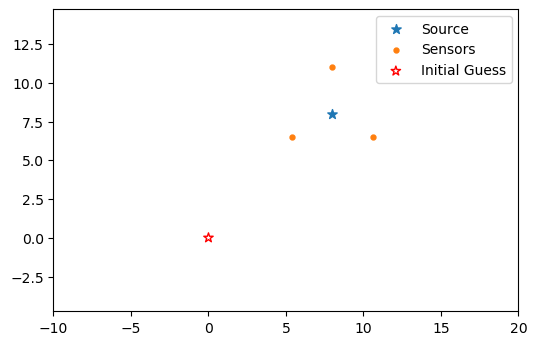

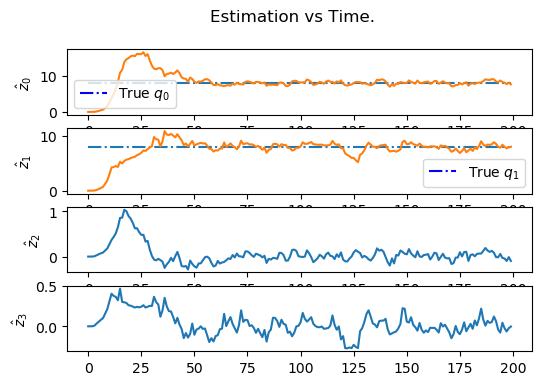

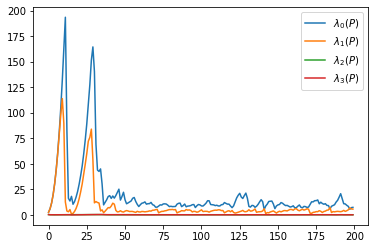

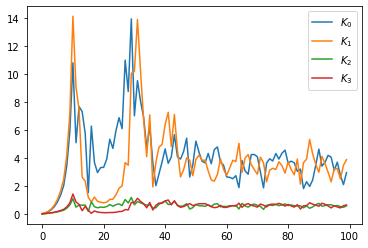

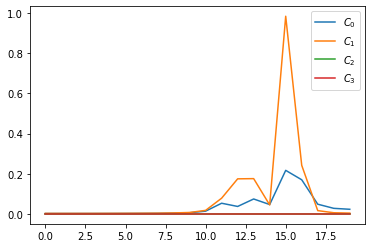

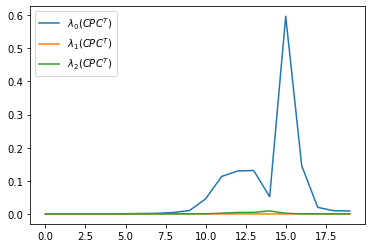

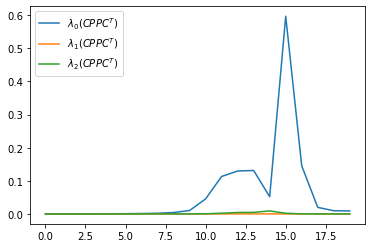

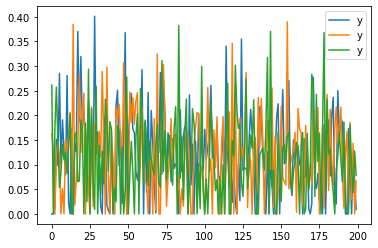

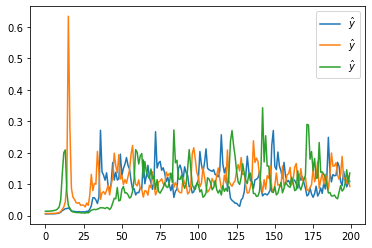

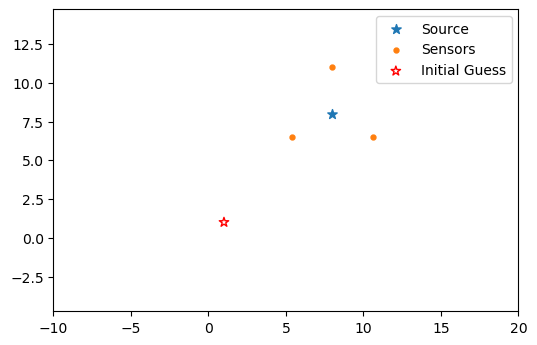

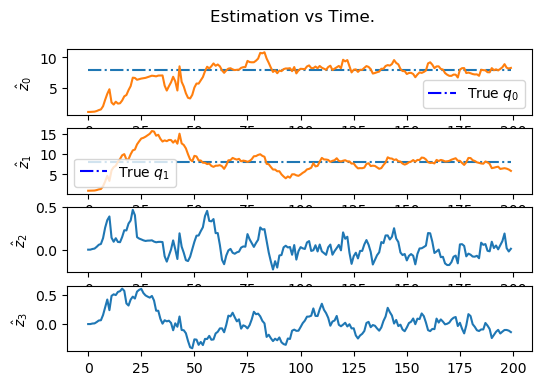

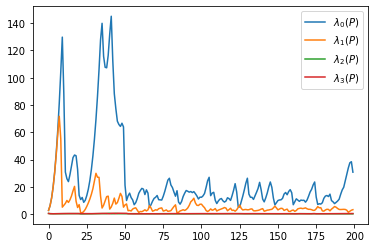

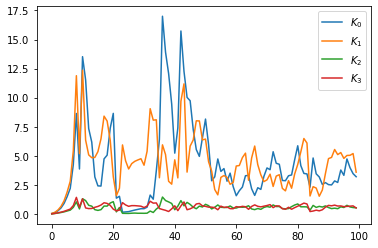

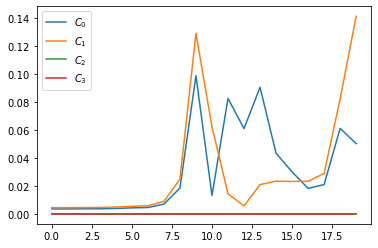

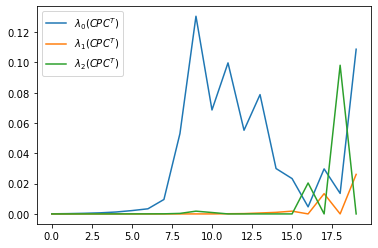

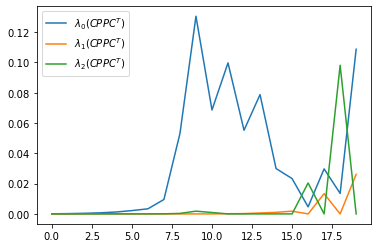

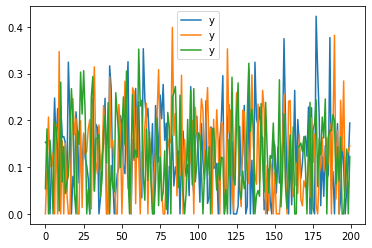

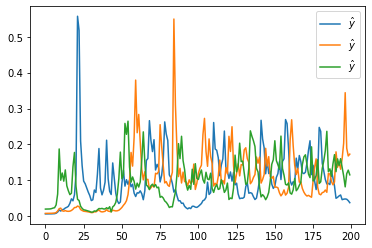

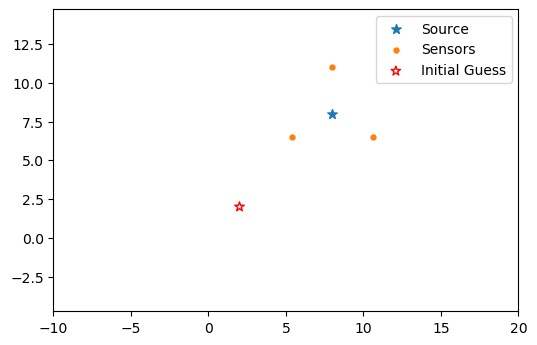

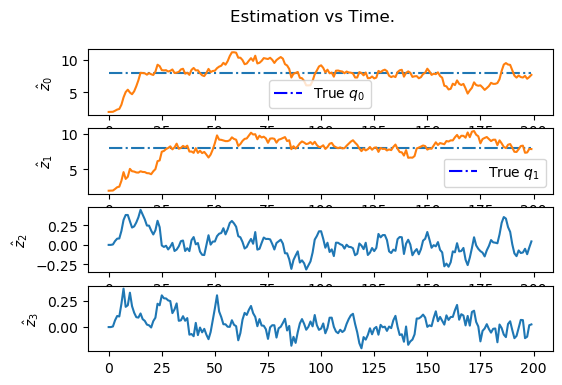

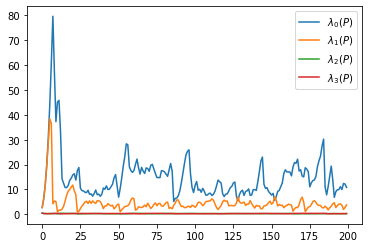

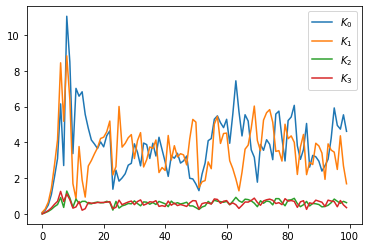

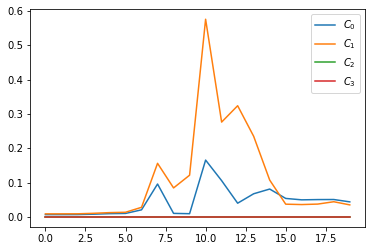

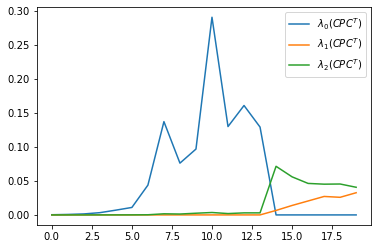

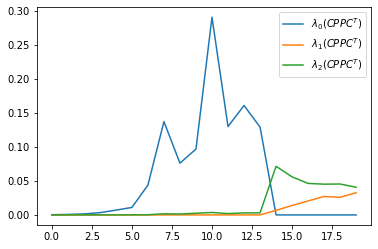

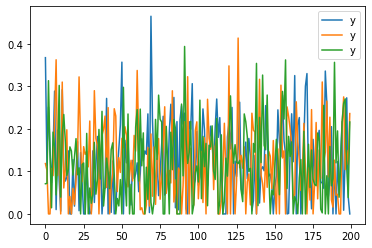

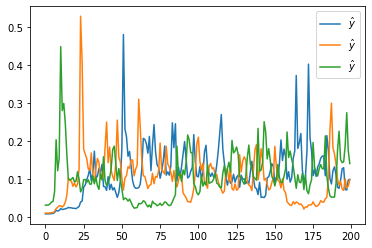

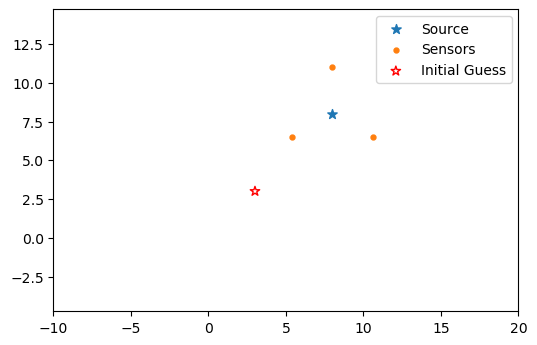

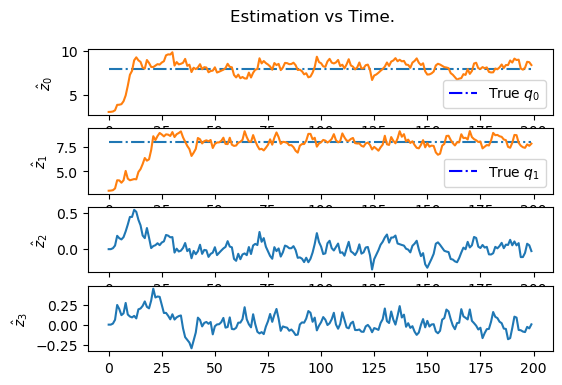

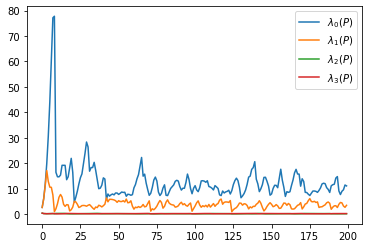

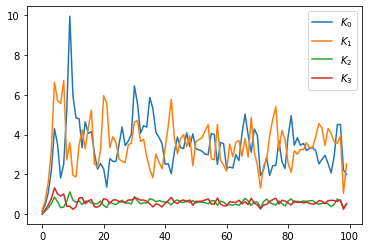

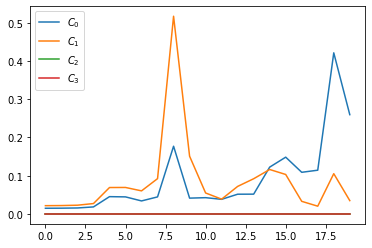

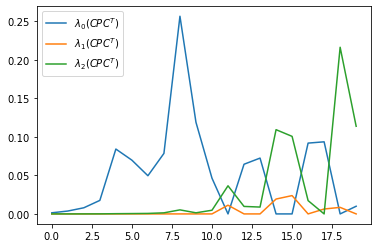

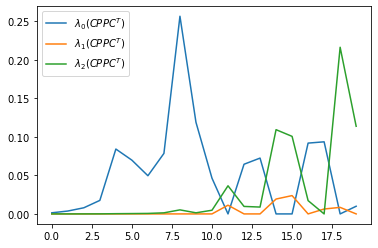

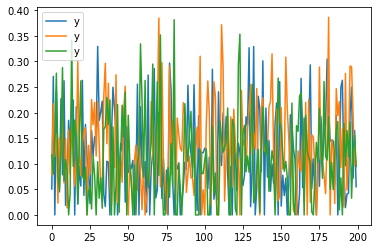

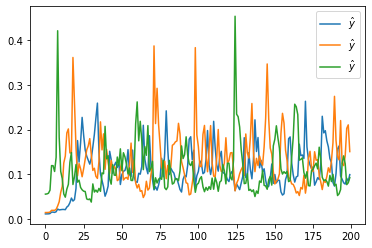

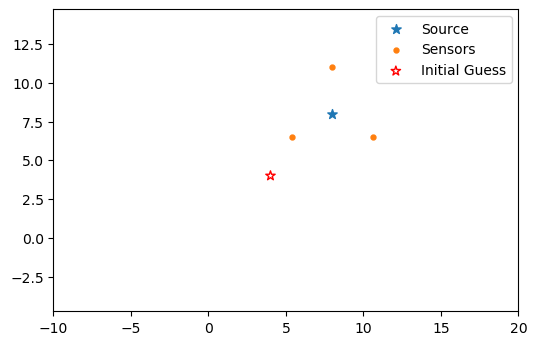

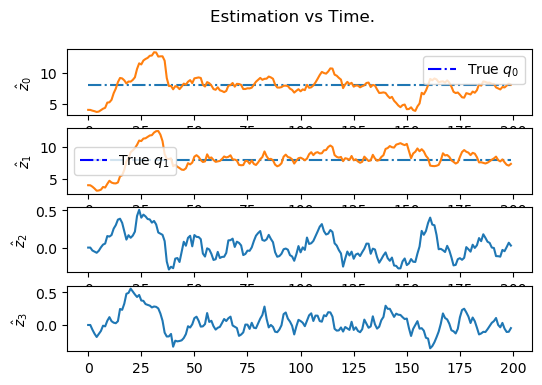

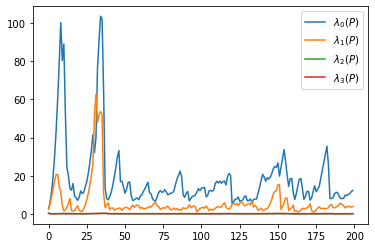

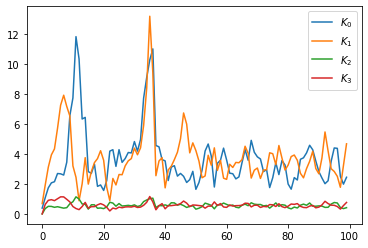

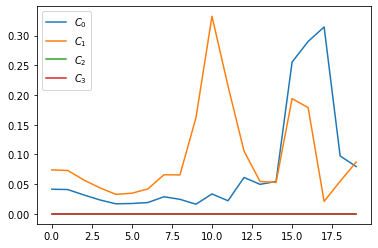

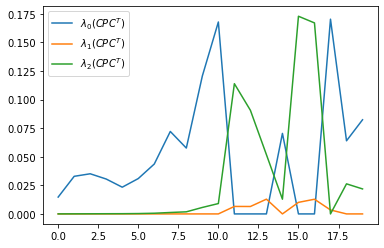

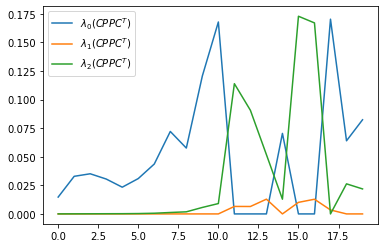

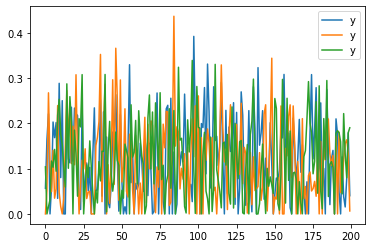

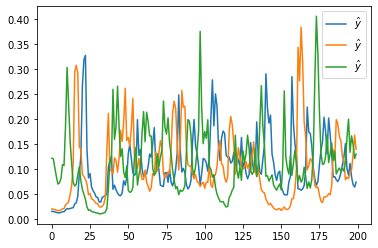

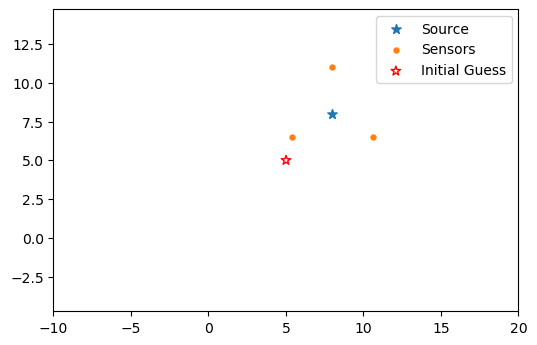

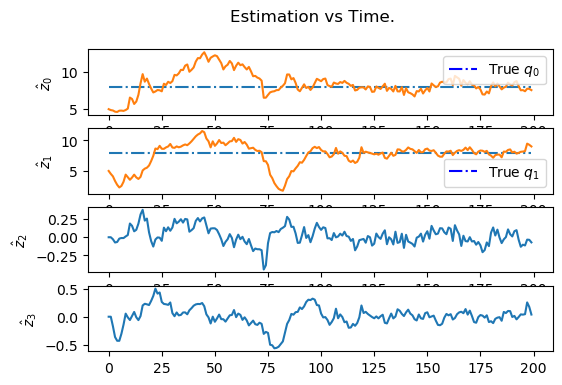

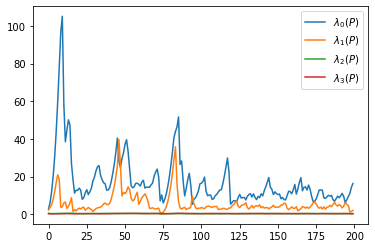

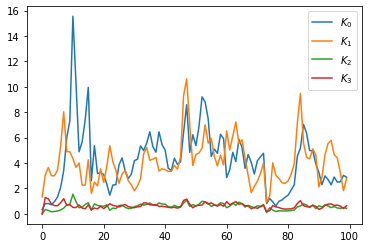

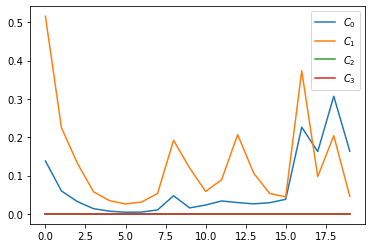

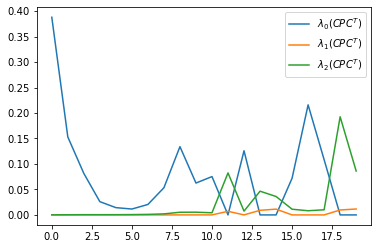

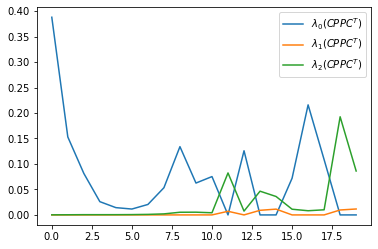

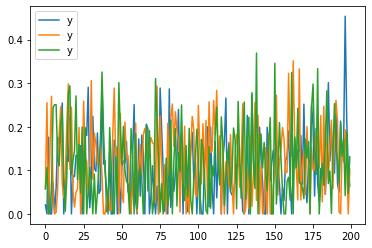

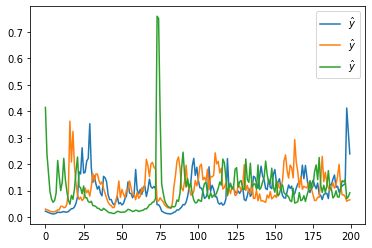

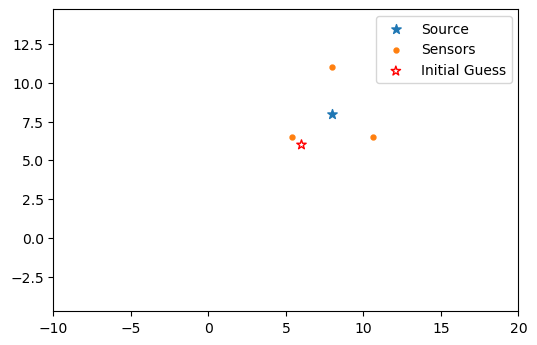

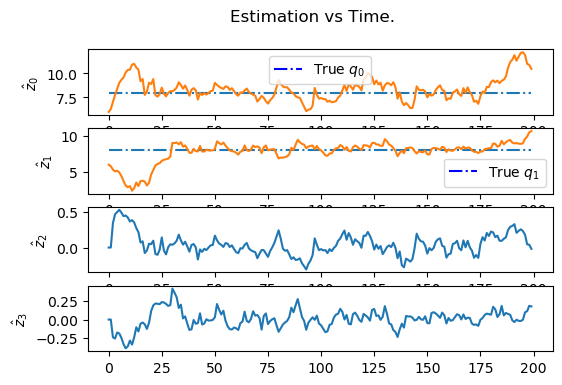

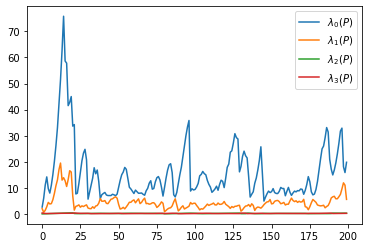

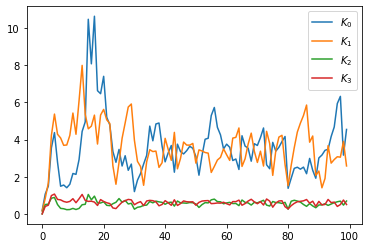

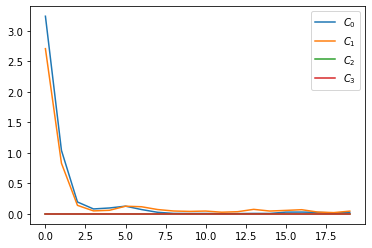

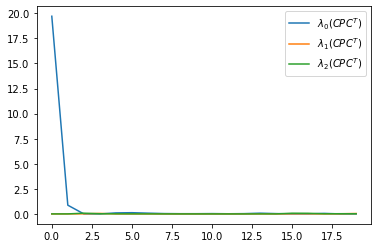

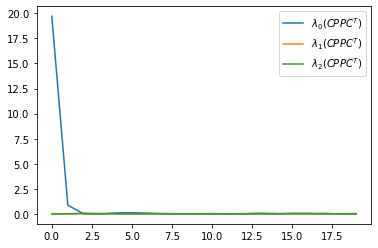

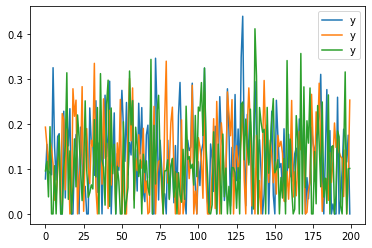

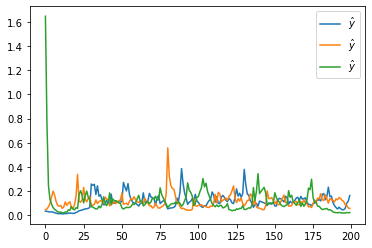

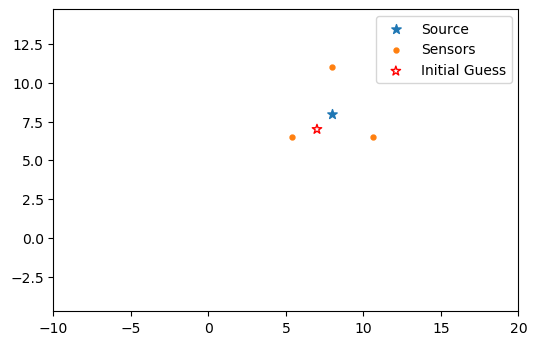

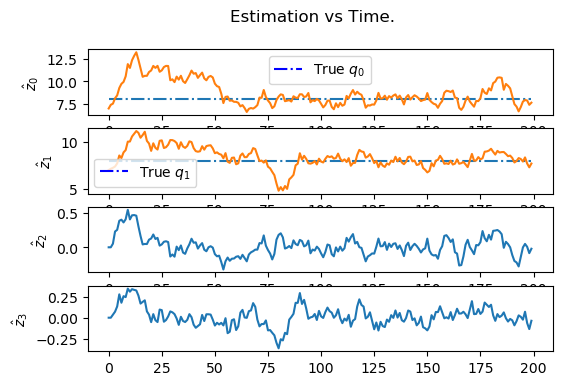

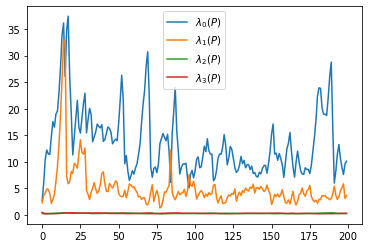

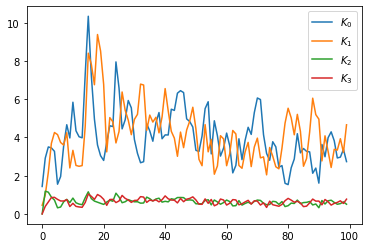

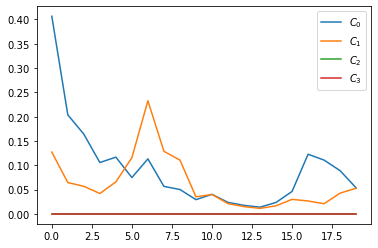

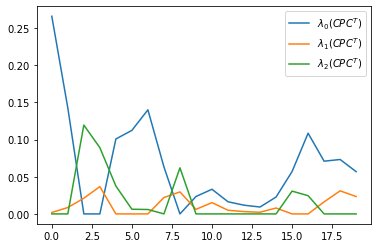

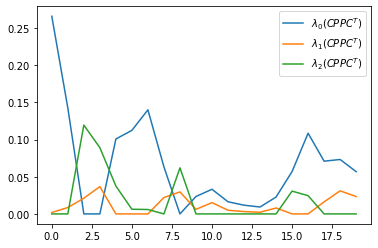

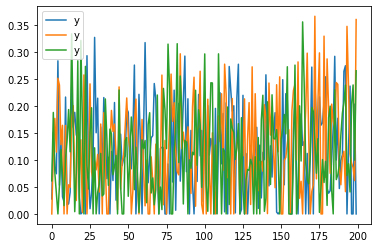

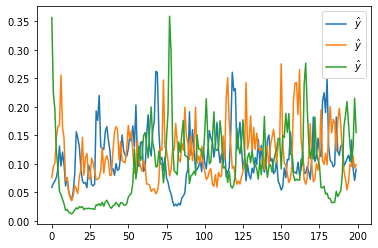

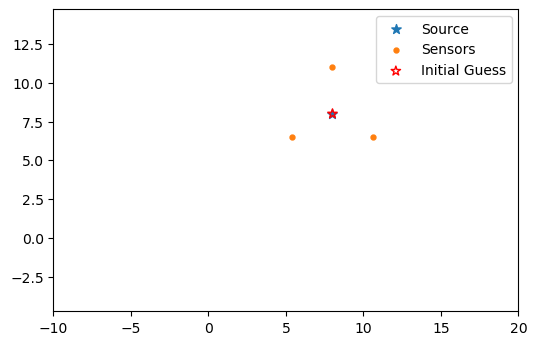

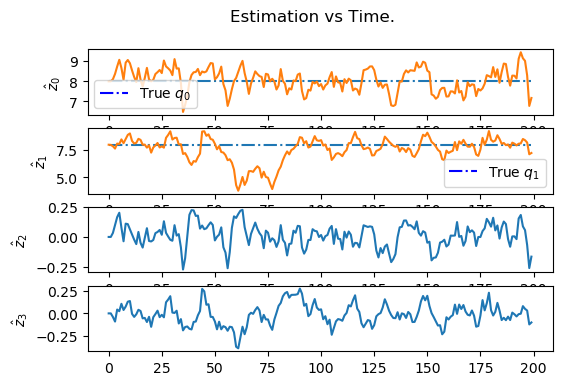

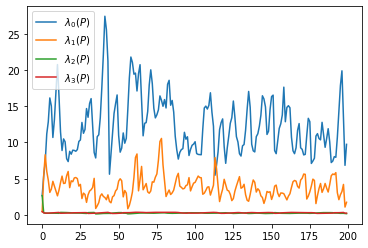

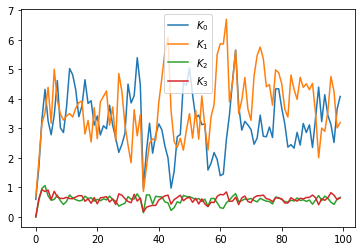

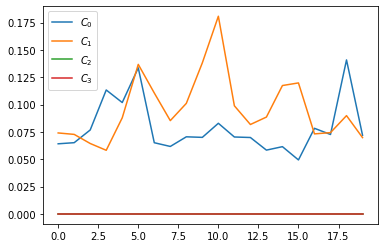

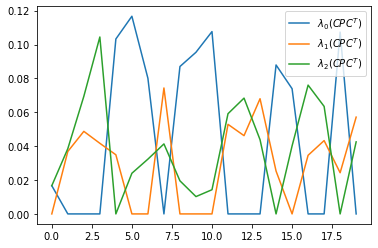

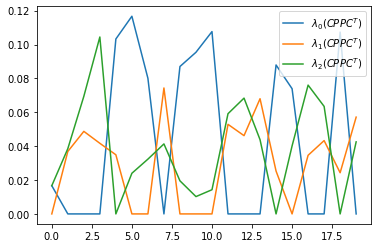

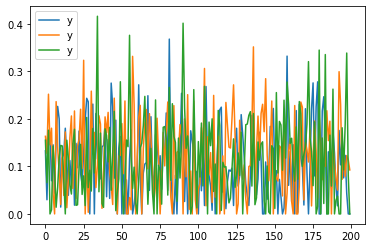

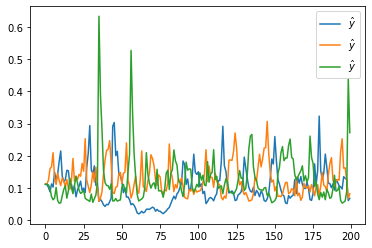

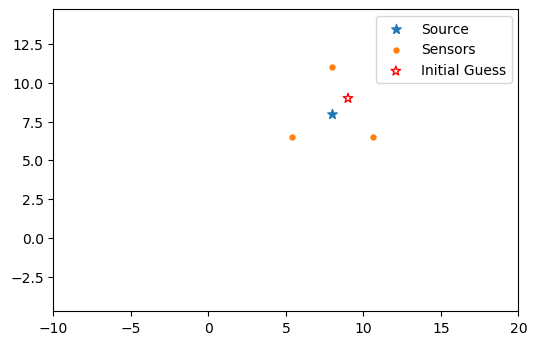

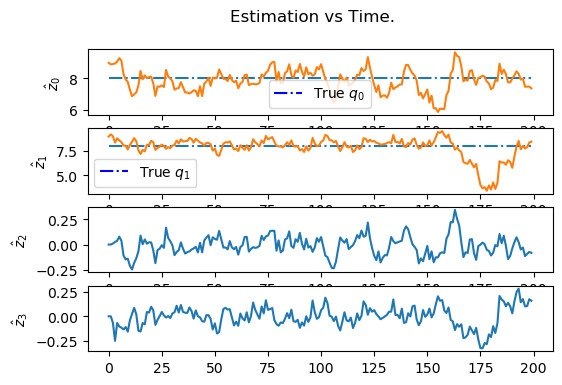

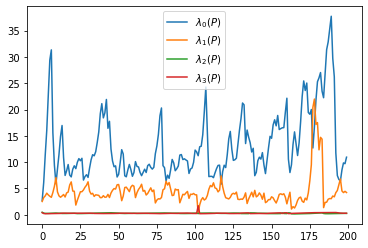

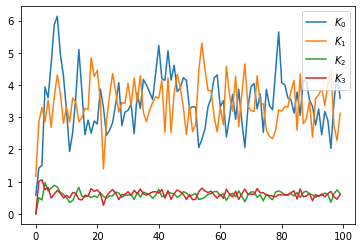

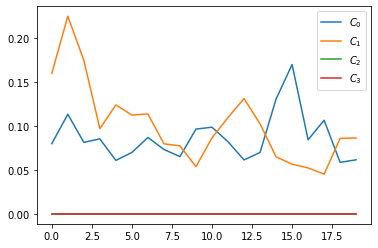

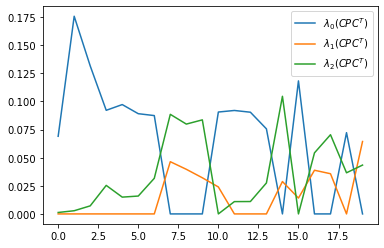

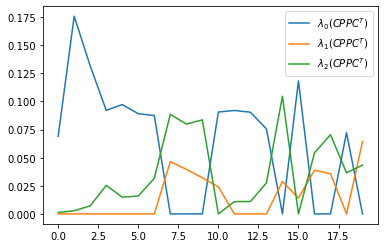

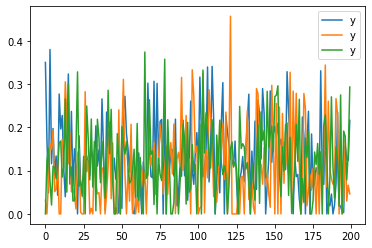

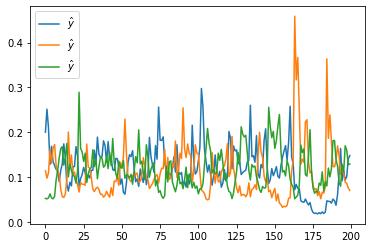

In [48]:
src_locs = np.array([[8.,8.]])
# sensor_center = src_locs
# r=0.5
# thetas = np.pi * 2 * np.linspace(0.5,0.75,3)
# sensor_locs =  r*np.vstack([np.sin(thetas),np.cos(thetas)]).T+sensor_center

r=3
thetas = np.pi * 2 * np.linspace(0,1,3,endpoint=False)
sensor_locs = r*np.vstack([np.sin(thetas),np.cos(thetas)]).T+np.array([[8.,8]])

# Simulating
initial_guesses = np.vstack([range(10),range(10)]).T
# initial_guesses = np.array([[6,6]])
recs = []
for i in range(len(initial_guesses)):
    q_0 = initial_guesses[i,:]
    record = main(sensor_locs,src_locs,q_0,200)
    recs.append(record)
    # filepath = "EKF-Div-Study.pkl"
    # with open(filepath,'wb') as file:
    #     pkl.dump(record,file)


# Visualization

for record in recs:
    zhats = record['est_locs_log']['Estimation']
    # Plot sensor, src locations, and qhats.

    fig, ax = plt.subplots(dpi=100)
    ax.cla()
    ax.scatter(src_locs[0,0],src_locs[0,1],marker='*',s=50,label='Source')
    ax.scatter(sensor_locs[:,0],sensor_locs[:,1],marker='.',s=50,label='Sensors')
#     ax.scatter(zhats[:,0],zhats[:,1],marker='*',s=50,label='Estimations',facecolor="None",edgecolor='b')
    ax.scatter(zhats[0,0],zhats[0,1],marker='*',s=50,label='Initial Guess',facecolor="None",edgecolor='r')

    ax.axis('on')
    ax.axis('equal')
    ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
    ax.set_xlim((-10,20))
    ax.set_ylim((-10,20))
    ax.legend()
    # ax.set_title()
    plt.show()


    # Plot z in time
    fig, ax = plt.subplots(4,dpi=100)

    fig.suptitle('Estimation vs Time.')
    for _ in range(4):
        if _<2:
            ax[_].plot(range(len(zhats)),src_locs[:,_]*np.ones(len(zhats)),'-.')
            custom_lines = [Line2D([0], [0], color='blue', ls='-.'),]
            ax[_].legend(custom_lines, ['True $q_{}$'.format(_)])
        for name,est in record['est_locs_log'].items():
            ax[_].plot(est[:,_])
            ax[_].set_ylabel(r'$\hat z_{}$'.format(_))
    plt.show()
    # Plot filtering parameters

    eig_P = np.array([np.linalg.eigvals(P) for P in record['Ps']])
#     print(eig_P)
    for i in range(eig_P.shape[1]):
        plt.plot(eig_P[:,i],label=r'$\lambda_{}(P)$'.format(i))
    plt.legend()
    plt.show()
    
    ave_K = np.array([np.max(np.abs(K),axis=1) for K in record['Ks']])
    for i in range(ave_K.shape[1]):
        plt.plot(ave_K[:100,i],label=r'$K_{}$'.format(i))
    plt.legend()
    plt.show()
    
    ave_C = np.array([np.max(np.abs(C),axis=0) for C in record['Cs']])
    for i in range(ave_C.shape[1]):
        plt.plot(ave_C[:20,i],label=r'$C_{}$'.format(i))
    plt.legend()
    plt.show()
    
    Ps = record['Ps']
    Cs = record['Cs']
    cPc = [C.dot(P).dot(C.T) for P,C in zip(Ps,Cs)]
    eig_cPc = np.array([np.abs(np.linalg.eigvals(A)) for A in cPc ])
    for i in range(eig_cPc.shape[1]):
        plt.plot(eig_cPc[:20,i],label=r'$\lambda_{}(CPC^T)$'.format(i))
    plt.legend()
    plt.show()
    
    cPPc = [C.dot(P).dot(P).dot(C.T) for P,C in zip(Ps,Cs)]
    eig_cPPc = np.array([np.abs(np.linalg.eigvals(cPPc)) for A in cPc ])
    for i in range(eig_cPc.shape[1]):
        plt.plot(eig_cPc[:20,i],label=r'$\lambda_{}(CPPC^T)$'.format(i))
    plt.legend()
    plt.show()
    
    
    plt.title("")
    plt.plot(record['ys'],label='y')
    plt.legend()
    plt.show()
  
    plt.plot(record['yhats'],label='$\hat{y}$')
    plt.legend()
    plt.show()
  

## Conclusion

For the $h(r)=1/r^2$ measurement model, given the same level of estimation error $||q-\hat{q}||$, the ratio $\frac{|y-\hat{y}|}{||q-\hat{q}||}$ is large when $p$ is close to $q$, i.e. the response from estimation error to measurement error is large when the sensors are close to the source. 

In this scenario, the filter correction step is very likely to be ticked off by such a large $|y-h(p,\hat{q})|$ value, and overshoot the next $\hat{q}$ and $\hat{v}$ to a region that is even farther away than the one in the previous iteration.

This usually makes $\hat{q}$ very away from $p$, resulting in $h(p,\hat{q})\approx 0$ and $C=\nabla_q h(P,\hat{q})\approx0$. This further makes $K\approx0$. Note now the error $|y-h(p,\hat{q}|\approx y>0$ while $K|y-h(p,\hat{q}|\approx 0$, i.e. the filter enters a stage where the Kalman Gain is near zero, there will be no correction on current $\hat{v}$ value, the estimator falls into a constant-velocity free fall. The filter keeps doing the prediction step to send the estimated positioin $\hat{q}$ into a constant velocity motion, moving steadily farther away from the true value.

We observe that, if the source-sensor distance is not too small, the estimation is indeed less likely to fall into the scenario described above, and the estimation is much more likely to converge even if the initial guess is far away from the true value.

The fundamental problem revealed here is the fact that EKF linearize the system around an estimated value, that is  $C=\nabla_q h(p,\hat{q})\approx0$ involves the estimated $\hat{q}$ , so $C$ does NOT represent the true dynamics, but is rather an estimation in itself, and the difference between $C$ and the true dynamics can enlarge over time. Compared with conventional linear Kalman Filter, where we usually know the true $C$ value, EKF really is doing some very risky stuff.

## What can be done to fix this?
* Stop using EKF for such measurement models who goes to infinity approaching 0! Switch to dynamics-free methods like deterministic least square, or Unscented KF or Particle Filter.
* Keep using EKF, but only when the sensors are not too close to the source, or more practically when the sensor readings are weak. Switch to the aforementioned methods that deals with non-linearity better.